# Englacial borehole temperature modelling experiments

#### 

***

#### 


## 1. Introduction
This notebook demonstrates how to run and plot results from a python version of the simple one-dimensional englacial temperature model presented in: 

Montelli, A. and Kingslake, J.: Geothermal heat flux is the dominant source of uncertainty in englacial-temperature-based dating of ice-rise formation, 2022, EGUsphere [preprint], https://doi.org/10.5194/egusphere-2022-236.

Ultimately, the primary purpose of the paper is to examine what information (and with what uncertainties) about climate and glacial history can be inferred from englacial temperatures measured within ice rises - regions of slow-flowing, locally elevated, grounded ice embedded within or adjacent to fast-flowing, floating ice shelves. Due to their proximity to the marine ice-sheet periphery and negligible horizontal flow, ice rises can retain an imprint of past grounding line migration on millennial timescales, a record that is otherwise largely inaccessible beneath the ice sheet or its fringing ice shelves.

Digitized borehole measurements and input datasets that were used to produce some of the results can be found [here](https://github.com/sashamontelli/borehole_temperature_models).

This notebook summarizes the model and the implementation of the python code to solve the equations. It also demonstrates sensitivity experiments and inversion of borehole measurements presented in the paper.

***

#### 


## 2. The model
Refer to the paper cited above for the full details of the model equations. Here we will summarize it so users get some familiarity with the physics and the variables being solved for. 

### 2.1. Equations

The model solves the vertical diffusion-advection equation to simulate the time- and depth-evolution of temperature through one-dimensional column of slow-flowing ice (i.e., ice where horizontal flow component is negligibly small). It is described by the following partial differential equation:

\begin{equation}
  \label{eq:Adv_dif}
  \frac{\partial T}{\partial t}  =  \alpha \left( \frac{\partial}{\partial z} \right)  \frac{\partial T}{\partial z} - w \frac{\partial T}{\partial z}  \;, \tag{1}
\end{equation}

where ${t}$ is time, ${z}$ is height above the bed, ${w}$ is vertical ice velocity (positive upwards) and ${\alpha}$ is thermal diffusivity: 

\begin{equation}
  \label{eq:Alpha}
  \alpha = \frac{k} {\rho c} 
  \;, \tag{2}
\end{equation}


Where ${\rho}$ is density, ${k}$ is the thermal conductivity, ${c}$ is the specific heat capacity, and ${w}$ is vertical velocity within the ice column. For sensitivity experiments, we implement three analytical approximations for vertical velocity within grounded ice. The Dansgaard and Johnsen (1969) vertical flow approximation can be formulated as:

\begin{equation}
  \label{eq:vwDJ1}
  w(z,z_k) = -w_s(t) \frac{2z - z_k} {2H - z_k}    
  \;, \tag{3}
\end{equation}


for   \begin{equation}
  \label{eq:vwDJ1c}
  z_k \leqslant z \leqslant H  
  \;, 
\end{equation}

and

\begin{equation}
  \label{eq:vwDJ2}
  w(z,z_k) = -w_s(t) \frac{z^2} {(2H - z_k)z_k }
  \;, \tag{4}
\end{equation}


for   \begin{equation}
  \label{eq:vwDJ2c}
  0 \leqslant z \leqslant z_k  
  \;, 
\end{equation}

Another commonly used vertical flow approximation by Lliboutry (1979) can be formulated as:


for   \begin{equation}
  \label{eq:vwLl}
  w(z,t) = w_s(t) \left[ 1 - \frac{n + 2}{n + 1}\left(1 - \frac{z}{H(t)}\right) + \frac{1}{n + 1}\left(1 - \frac{z}{H(t)}\right)^{n+2} \right]
  \;, \tag{5}
\end{equation}

where ${n}$ is a rheological parameter (Glen's flow law exponent).

Finally, a simplified approximation where vertical velocity varies linearly with depth from zero at the base to a maximum value at the surface, following Bindschadler et al (1990), was implemented for sensitivity experiments and estimation of associated uncertainties:
  
\begin{equation}
  \label{eq:vwBind}
  w(z,t) = w_s(t)  \frac {z}{H(t)} 
  \;, \tag{6}
\end{equation}

When time-varying ice thickness is introduced, the difference between accumulation and thickening rates determines the vertical velocity at the surface:

\begin{equation}
  \label{eq:vwBind1}
  w_s(t) = a(t) -  \frac {\partial H(t)}{\partial t} 
  \;, \tag{7}
\end{equation}

For temperature calculations within the underlying bedrock, no vertical advection is assumed (${w}=0$), reducing Eq. 1 to only account for heat diffusion.

### 2.2. Numerics and boundary conditions

A one-dimensional spatial domain is defined, extending vertically from the bedrock base to the ice surface. The vertical coordinate is ${z}$, which increases upwards. A simple finite-difference scheme is implemented to solve Eq. 1. The spatial domain is discretisized with a minimum of 50 nodes within the ice column and 50 nodes with fixed 10 m vertical spacing in the subjacent bedrock. Time step is set to equal 1 year. In a scenario where ice thickness varies through time, vertical grid spacing in the ice column is adapted and temperature values are interpolated accordingly at each time step. The model can be run under two different assumptions about whether the ice column is a part of a grounded ice rise or a floating ice shelf.

In the ice-shelf scenario boundary conditions at the ice surface are set by time-variable surface temperatures ${T(t)}$ and accumulation rates ${a(t)}$. The temperature at the top of bedrock/base of ice column ${T(z=z_b)}$ is forced to equal the freezing point of seawater (calculated as a function of ice thickness, to account for its pressure dependence), and the temperature gradient in the bedrock is calculated based on the geothermal heat flux ${G}$. The rates of accumulation and basal melting are assumed to balance each other out.

When modelling temperatures within a grounded ice sheet (i.e., an ice rise), the boundary condition at the base of the ice column is set such that the vertical gradient in ${T}$ corresponds to a diffusive heat flux that balances the geothermal heat flux ${G}$ through the underlying bedrock. Thickness history ${H(t)}$ and the vertical velocity function (Eqs. 3-6) within the ice rise are also used. The boundary conditions at the top of the ice column are prescribed based on the temperature and accumulation rate histories.

#### 


***

#### 


## 3. Forward model code demonstration


### 3.1. Importing the required modules

Several modules will be needed to implement the presented version of the code.

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import time
import math
import random
import time
import dask
import dask.bag as db
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline
import emcee # need to run in terminal beforehand: 'conda install -c conda-forge emcee'
from multiprocessing import Pool
from tqdm import tqdm
import h5py
import matplotlib.font_manager
from netCDF4 import Dataset 
import netCDF4 as nc
import xarray as xr
import gcsfs
import fsspec
import cartopy.crs as ccrs
import cmocean
import multiprocessing as mp
import geopandas as gpd
import json
import geoplot
import cartopy.feature as cfe
import pyproj
import pandas as pd
import cartopy.feature as cfe
import pyproj
import scipy

Here, plotting parameters are set for the figures and fonts used therein.

In [2]:
mpl.rcParams['figure.figsize'] = 12, 7
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300

plt.rcParams.update({
    'font.sans-serif': 'Arial', # need to run conda install -c conda-forge -y mscorefonts for Arial
    'font.family': 'Arial',
    'font.size': 11,
    'figure.titlesize': 12,
    'figure.titleweight': 'bold',
    'lines.linewidth' : 0.5,
    'lines.markersize' : 2,
    'xtick.labelsize' : 10,
    'ytick.labelsize' : 10,
    'grid.linewidth': 0.1,
    'axes.titlesize': 11,
    'axes.titleweight' : 'bold',
    'axes.labelsize': 11,
    'axes.labelweight': 'bold',
    'axes.linewidth': 0.5,
    'pdf.fonttype': 42
})

### 3.2. Loading the required parameters for temperature calculation

Several constants and parameter values are required prior to running the code.

A full list of the predefined constants is in the table below.

| Constant | Default value | Description |
| --- | --- | --- |
`c_i`|`2000`|Heat capacity of ice (${J}$ $kg^{-1}$ $K^{-1}$)
`c_r`|`790`|Heat capacity of bedrock (${J}$ $kg^{-1}$ $K^{-1}$)
`k_i`|`2.3`|Thermal conductivity of ice at ~260ºK (${W}$ $m^{-1}$ $K^{-1}$)
`k_r`|`2.8`|Thermal conductivity of bedrock (${mW}$ $m^{-2}$)
`rho_i`|`918`|Density of ice (${kg}$ $m^{3}$)
`rho_r`|`2750`|Density of bedrock (${kg}$ $m^{3}$)
`n`|`3`|Glen's flow law exponent
`g`|`9.18`| Gravitational acceleration (${m}$ $s^{-2}$)
`A`|`2e-16`|Rheological constant determining soft ice as a function of temperature

Note that thermal conductivity is assumed constant here; in reality, however, conductivity of ice is temperature-dependant (e.g., ranging from from 2 ${W}$ $m^{-1}$ $K^{-1}$ (for ice close to the pressure melting point) to 2.6 ${W}$ $m^{-1}$ $K^{-1}$ for ice at -30ºC. Temperature-dependent conductivity effects can be explored in sensitivity experiments similar to those presented further in this notebook.

In [3]:
c_i = 2e3 # Heat capacity of ice
c_r = 7.9e2 # Heat capacity of basal rock
k_i = 2.3 # Thermal conductivity of ice
k_r = 2.8 # Thermal conductivity of basal rock
rho_i = 918 # Density of ice
rho_r = 2750 # Density of basal rock
alpha_i = k_i / rho_i / c_i # Alpha for ice
alpha_r = k_r / rho_r / c_r # Alpha for basal rock
n = 3 # Glen's flow law exponent
g = 9.81 # Gravitational acceleration
A = 2e-16 # Rheological constant determining soft ice as a function of temperature

yr_to_s = 365.25*24*60*60 # Seconds in a year
dt_years = 1  # Temporal resolution / time step in years
dt = (dt_years*yr_to_s) #  Temporal resolution / calculation of time step in seconds

### 3.3. Defining the model

The model is written as a function of several variables for convenient execution of numerous sensitivity tests that will follow. In this case, model takes the following variables as an input:

| Parameter |Description |
| --- | --- |
`H_i`|Ice thickness history ${H(t)}$
`H_r`|Time-constant thickness of subglacial bedrock
`dz`|Spatial grid resolution in metres
`t_steady_years_total`|Time (in years) required to reach steady state temperature profile
`t_forcing_years`|Time period ${t}$ (in years) when forcings are time-variable
`t_ungrounding`|Time (years before present) when ice becomes ungrounded
`t_grounding`|Time (years before present) when ice becomes grounded
`T_sim`|Temperature history ${T(t)}$
`a_sim`|Accumulation history ${a(t)}$
`G`|Geothermal heat flux 

The model using a simple finite different scheme is defined below. 

In [4]:
def Tmodel(Hi_sim, Hr, dz, t_steady_years_total, t_forcing_years, t_ungrounding, t_grounding, T_sim, a_sim, G):

##################################################################################################################
    
    #### Defining spatial and temporal domains / resolution

    Hm = min(Hi_sim)  # Taking the minimum value of thickness history for domain calculation
    zi = np.linspace(0, Hm, int((Hm)/dz) + 1)  # Space calculation domain for ice
    dzr = dz  # Space resolution for bedrock
    zr = np.linspace(-Hr, 0, int(Hr/dz) + 1) #  Space calculation domain for bedrock
    l = len(zr)  # Index for ice-bed interface to be used in the loop calculations 
    Lzi = len(zi) #  Number of elements in space domain for ice
    Lzr = len(zr) #  Number of elements in space domain for bedrock
    z = np.concatenate((zr[:-1],zi))  #  Merging space domains for ice and bedrock into one single unified space domain
    Lz = len(z) # Calculating the number of nodes in the unified space domain

    Tvar_H_matrix = np.zeros((Lz,int(t_forcing_years))) # Preparing temperature matrix for each step of temperature calculations
    zvar_H_matrix = np.zeros((Lz,int(t_forcing_years))) # Preparing depth matrix for each step of temperature calculations
    
    #### Interpolating time-variable forcing vectors

    time_sim_T = np.linspace(1, int(t_forcing_years), num=len(T_sim))  # Creating an evenly spaced time vector for input surface temperature vector
    time_sim_Hi = np.linspace(1, int(t_forcing_years), num=len(Hi_sim)) # Creating an evenly spaced time vector for input thickness vector
    time_sim_a = np.linspace(1, int(t_forcing_years), num=len(a_sim)) # Creating an evenly spaced time vector for input accumulation vector
    tmnew = np.linspace(1, t_forcing_years, num = int(t_forcing_years), endpoint=True) # Creating a uniform time vector with 1-year spacing
    f = interp1d(time_sim_T, T_sim) # Preparing interpolation function
    facc = interp1d(time_sim_a, a_sim) # Preparing interpolation function
    fthk = interp1d(time_sim_Hi, Hi_sim) # Preparing interpolation function
    
    thkhistory = fthk(tmnew) # Interpolating thickness vector over the new time vector
    temphistory = f(tmnew) # Interpolating surface temperature vector over the new time vector
    acchistory_yr = facc(tmnew) # Interpolating accumulation vector over the new time vector
    
    acchistory = acchistory_yr / yr_to_s # Converting accumulation vector from m/yr to m/s
    
    a_steady = acchistory[0] # Taking the first value of the accumulation vector for steady state profile calculation
    Ts_surf_steady = temphistory[0] # Taking the first value of the temperature vector for steady state profile calculation
    Ts = -z*0 + Ts_surf_steady # Creating the initial temperature vector prior to the steady state profle calculation
    
    #### Defining time before ungrounding/grounding events
    
    t_before_ungrounding = int(t_forcing_years) - int(t_ungrounding) - int(t_grounding) # Defining the time before the ungrounding
    t_before_grounding =  int(t_forcing_years) - int(t_grounding)  # Defining the time before the grounding

##################################################################################################################
    
# Start of loop iterations

### Grounded ice steady state T profile with constant ice thickness:
    
    for i in range(0, int(t_steady_years_total)):

        Hi = thkhistory[0]  # Taking the first value of thickness history for steady state calculation
        zi = np.linspace(0, Hi, Lzi)  #  Space calculation domain for ice of initial thickness
        dz = Hi/Lzi  # Space resolution for ice column
        z = np.concatenate((zr[:-1],zi))  #  Merging space domains for ice and bedrock into one single unified space domain
        
        
       # Grounded ice vertical velocity profile after Lliboutry (1979)

        dws = a_steady  
        wzt = (1 - (((n + 2) / (n + 1)) * (1 - zi / Hi)) + (1 / (n + 1)) * np.power((1 - zi / Hi), (n + 2)))
        ws = -dws * wzt 

        # Advection-diffusion temperature calculation above ice-rock interface
        
        Ts[l:-1] = Ts[l:-1] + dt*(alpha_i*(Ts[l+1:]-2*Ts[l:-1]+Ts[l-1:-2])/dz**2 - np.multiply(ws[1:-1],(Ts[l+1:]-Ts[l-1:-2])/(2*dz)))
        Ts[-1] = Ts_surf_steady # Temperature forcing is constant and equals the first value of the input surface temperature vector
        
        # Diffusion temperature calculation below ice-rock interface
    
        Ts[1:l] = Ts[1:l] + dt * alpha_r * (Ts[2:l+1]-2*Ts[1:l]+Ts[0:l-1])/dzr**2
        Ts[0] = Ts[1] + (G/k_r*dzr)
        
        
### Grounded ice T profile with time-variable forcings:

    for j in range(0, int(t_before_ungrounding)):
        
        
        #  Introducing time-variable ice thickness and recalculating ice column mesh grid at each step 
        
        Hi = thkhistory[j]
        zi = np.linspace(0, Hi, Lzi)
        dz = Hi/Lzi
        z = np.concatenate((zr[:-1],zi)) 
        
        #  Interpolating temperature profile at a previous time step on to the new(current) ice column grid
        
        zint = np.linspace(0, thkhistory[j-1], Lzi)
        s = InterpolatedUnivariateSpline(zint, Ts[l-1:], k=1) 
        
        Ts[l-1:] = s(zi)
        
    
        # Grounded ice vertical velocity profile after Lliboutry (1979)

        dws = acchistory[j] - ((thkhistory[j] - thkhistory[j - 1]) / dt); # When thickness is variable through time
        wzt = (1 - (((n + 2) / (n + 1)) * (1 - zi / Hi)) + (1 / (n + 1)) * np.power((1 - zi / Hi), (n + 2)))
        ws = -dws * wzt

        # Advection-diffusion temperature calculation above ice-rock interface
        
        Ts[l:-1] = Ts[l:-1] + dt*(alpha_i*(Ts[l+1:]-2*Ts[l:-1]+Ts[l-1:-2])/dz**2 - np.multiply(ws[1:-1],(Ts[l+1:]-Ts[l-1:-2])/(2*dz)))
        Ts[-1] = temphistory[j] # Temperature forcing equals value of the imported surface temperature vector at each point in time
        
        # Diffusion temperature calculation below ice-rock interface
    
        Ts[1:l] = Ts[1:l] + dt * alpha_r * (Ts[2:l+1]-2*Ts[1:l]+Ts[0:l-1])/dzr**2
        Ts[0] = Ts[1] + (G/k_r*dzr)


        # Recording the results into the temperature and depth matrixes
    
        Tvar_H_matrix[:,j] = Ts
        zvar_H_matrix[:,j] = z
        
        
### Introduce ungrounding event:

    for jj in range(0, int(t_ungrounding)):
        
        
        #  Recalculating ice column space domain based on thickness at each step 
        
        Hi = thkhistory[jj+t_before_ungrounding]
        zi = np.linspace(0, Hi, Lzi)
        dz = Hi/Lzi
        z = np.concatenate((zr[:-1],zi))        
    
        #  Interpolating temperature profile at a previous time step on to the new(current) ice column grid

        zint = np.linspace(0, thkhistory[jj+t_before_ungrounding-1], Lzi) 
        s = InterpolatedUnivariateSpline(zint, Ts[l-1:], k=1)
        Ts[l-1:] = s(zi)
        
        
        # Ice shelf vertical velocity profile (linear function)
    
        w = -np.linspace(acchistory[jj+t_before_ungrounding],acchistory[jj+t_before_ungrounding],Lzi) # In this case, vertical velocity is constant, and accumulation rate and basal melt/freeze rate are in balance, following Jenkins and Holland (1999). It could be modified to the one where velocity varies linearly from the surface to the base of the ice shelf.

        # Advection-diffusion temperature calculation above ice-rock interface
        
        Ts[l:-1] = Ts[l:-1] + dt*(alpha_i*(Ts[l+1:]-2*Ts[l:-1]+Ts[l-1:-2])/dz**2 - np.multiply(w[1:-1],(Ts[l+1:]-Ts[l-1:-2])/(2*dz)))
        Ts[-1] = temphistory[jj+t_before_ungrounding] # Temperature forcing is constant and equals the first value of the imported Monte-Carlo surface temperature vectors
        
        Ts[l-1] = -1.89 - 7.53e-4*Hi # Empirically-derived, thickness-dependent seawater freezing point
            
        # Diffusion temperature calculation below ice-rock interface

        Ts[1:l-1] = Ts[1:l-1] + dt*alpha_r*(Ts[2:l]-2*Ts[1:l-1]+Ts[0:l-2])/dzr**2
        Ts[0] = Ts[1] + (G/k_r*dzr)
        
        
        # Recording the results into the temperature and depth matrixes
        
        Tvar_H_matrix[:,jj+t_before_ungrounding] = Ts
        zvar_H_matrix[:,jj+t_before_ungrounding] = z
        
        
### Introduce grounding event:

    for jjj in range(0, int(t_grounding)):
        
        Hi = thkhistory[jjj+t_before_grounding]
        zi = np.linspace(0, Hi, Lzi)
        dz = Hi/Lzi
        z = np.concatenate((zr[:-1],zi))          
            
        #  Interpolating previous temperature profile on to the new ice column space domain
        
        zint = np.linspace(0, thkhistory[jjj+t_before_grounding-1], Lzi)
        s = InterpolatedUnivariateSpline(zint, Ts[l-1:], k=1)
        Ts[l-1:] = s(zi)
           
            
        # Grounded ice vertical velocity profile

        dws = acchistory[jjj+t_before_grounding] - ((thkhistory[jjj+t_before_grounding] - thkhistory[jjj+t_before_grounding - 1]) / dt) # When thickness is variable through time
        wzt = (1 - (((n + 2) / (n + 1)) * (1 - zi / Hi)) + (1 / (n + 1)) * np.power((1 - zi / Hi), (n + 2)))
        ws = -dws * wzt

        # Advection-diffusion temperature calculation above ice-rock interface
        
        Ts[l:-1] = Ts[l:-1] + dt*(alpha_i*(Ts[l+1:]-2*Ts[l:-1]+Ts[l-1:-2])/dz**2 - np.multiply(ws[1:-1],(Ts[l+1:]-Ts[l-1:-2])/(2*dz)))
        Ts[-1] = temphistory[jjj+t_before_grounding] # Temperature forcing is constant and equals the first value of the imported Monte-Carlo surface temperature vectors
        
        # Diffusion temperature calculation below ice-rock interface
    
        Ts[1:l] = Ts[1:l] + dt * alpha_r * (Ts[2:l+1]-2*Ts[1:l]+Ts[0:l-1])/dzr**2
        Ts[0] = Ts[1] + (G/k_r*dzr)
        
        
        # Recording the results into the temperature and depth matrixes
          
        Tvar_H_matrix[:,jjj+t_before_grounding] = Ts
        zvar_H_matrix[:,jjj+t_before_grounding] = z
        
        
        # Recording all of the results into the temperature-depth profile tuple that contains all calculations at each step of the simulation
    
    return {'Tmeasured':Ts, 'z':z, 'Tvar_H_Tmatrix':Tvar_H_matrix, 'zvar_H_Tmatrix':zvar_H_matrix}

### 3.4. Demo run of the function

To facilitate quantitative comparison between different temperature profiles, two functions are introduced. First function (**RMS**) calculates root-mean squared between two vectors of the same length following the following equation:


\begin{equation}
  \label{eq:RMS}
  RMS = \sqrt{\frac {\sum_{i=1}^n (T_m - T_p)^2} {n}}
  \;, \tag{8}
\end{equation}


where ${T_m}$ and ${T_p}$ are the measured and predicted temperatures at each grid point ${i}$, and ${n}$ is the number of grid points. The other function (**rsmpl**) resamples temperature profile into a regular grid with fixed spacing. 

#### Function to calculate root mean square standard error for finding best fit

In [5]:
def RMS(measured, model):
    d = 0
    for i in range(0,len(measured)):
        d1 = (measured[i] - model[i])**2
        d = d + d1
    RMS = math.sqrt(d/(len(measured)))
    return RMS

#### Function to resample temperature profiles into a required number of data points/vertical grid

In [6]:
def rsmpl(T_in, z_in, dz):
    flinear = interp1d(z_in, T_in)
    
    z_out = np.arange(0, int(max(z_in))+dz, dz)
    T_out = flinear(z_out)
    
    return [T_out, z_out]

#### Implementing the function and plotting the results

Here is an example of running the function and plotting the output. Here we try two different sets of variables and plot the resultant temperature profiles next to the borehole measurements reported from Crary Ice Rise by Bindschadler et al (1991).

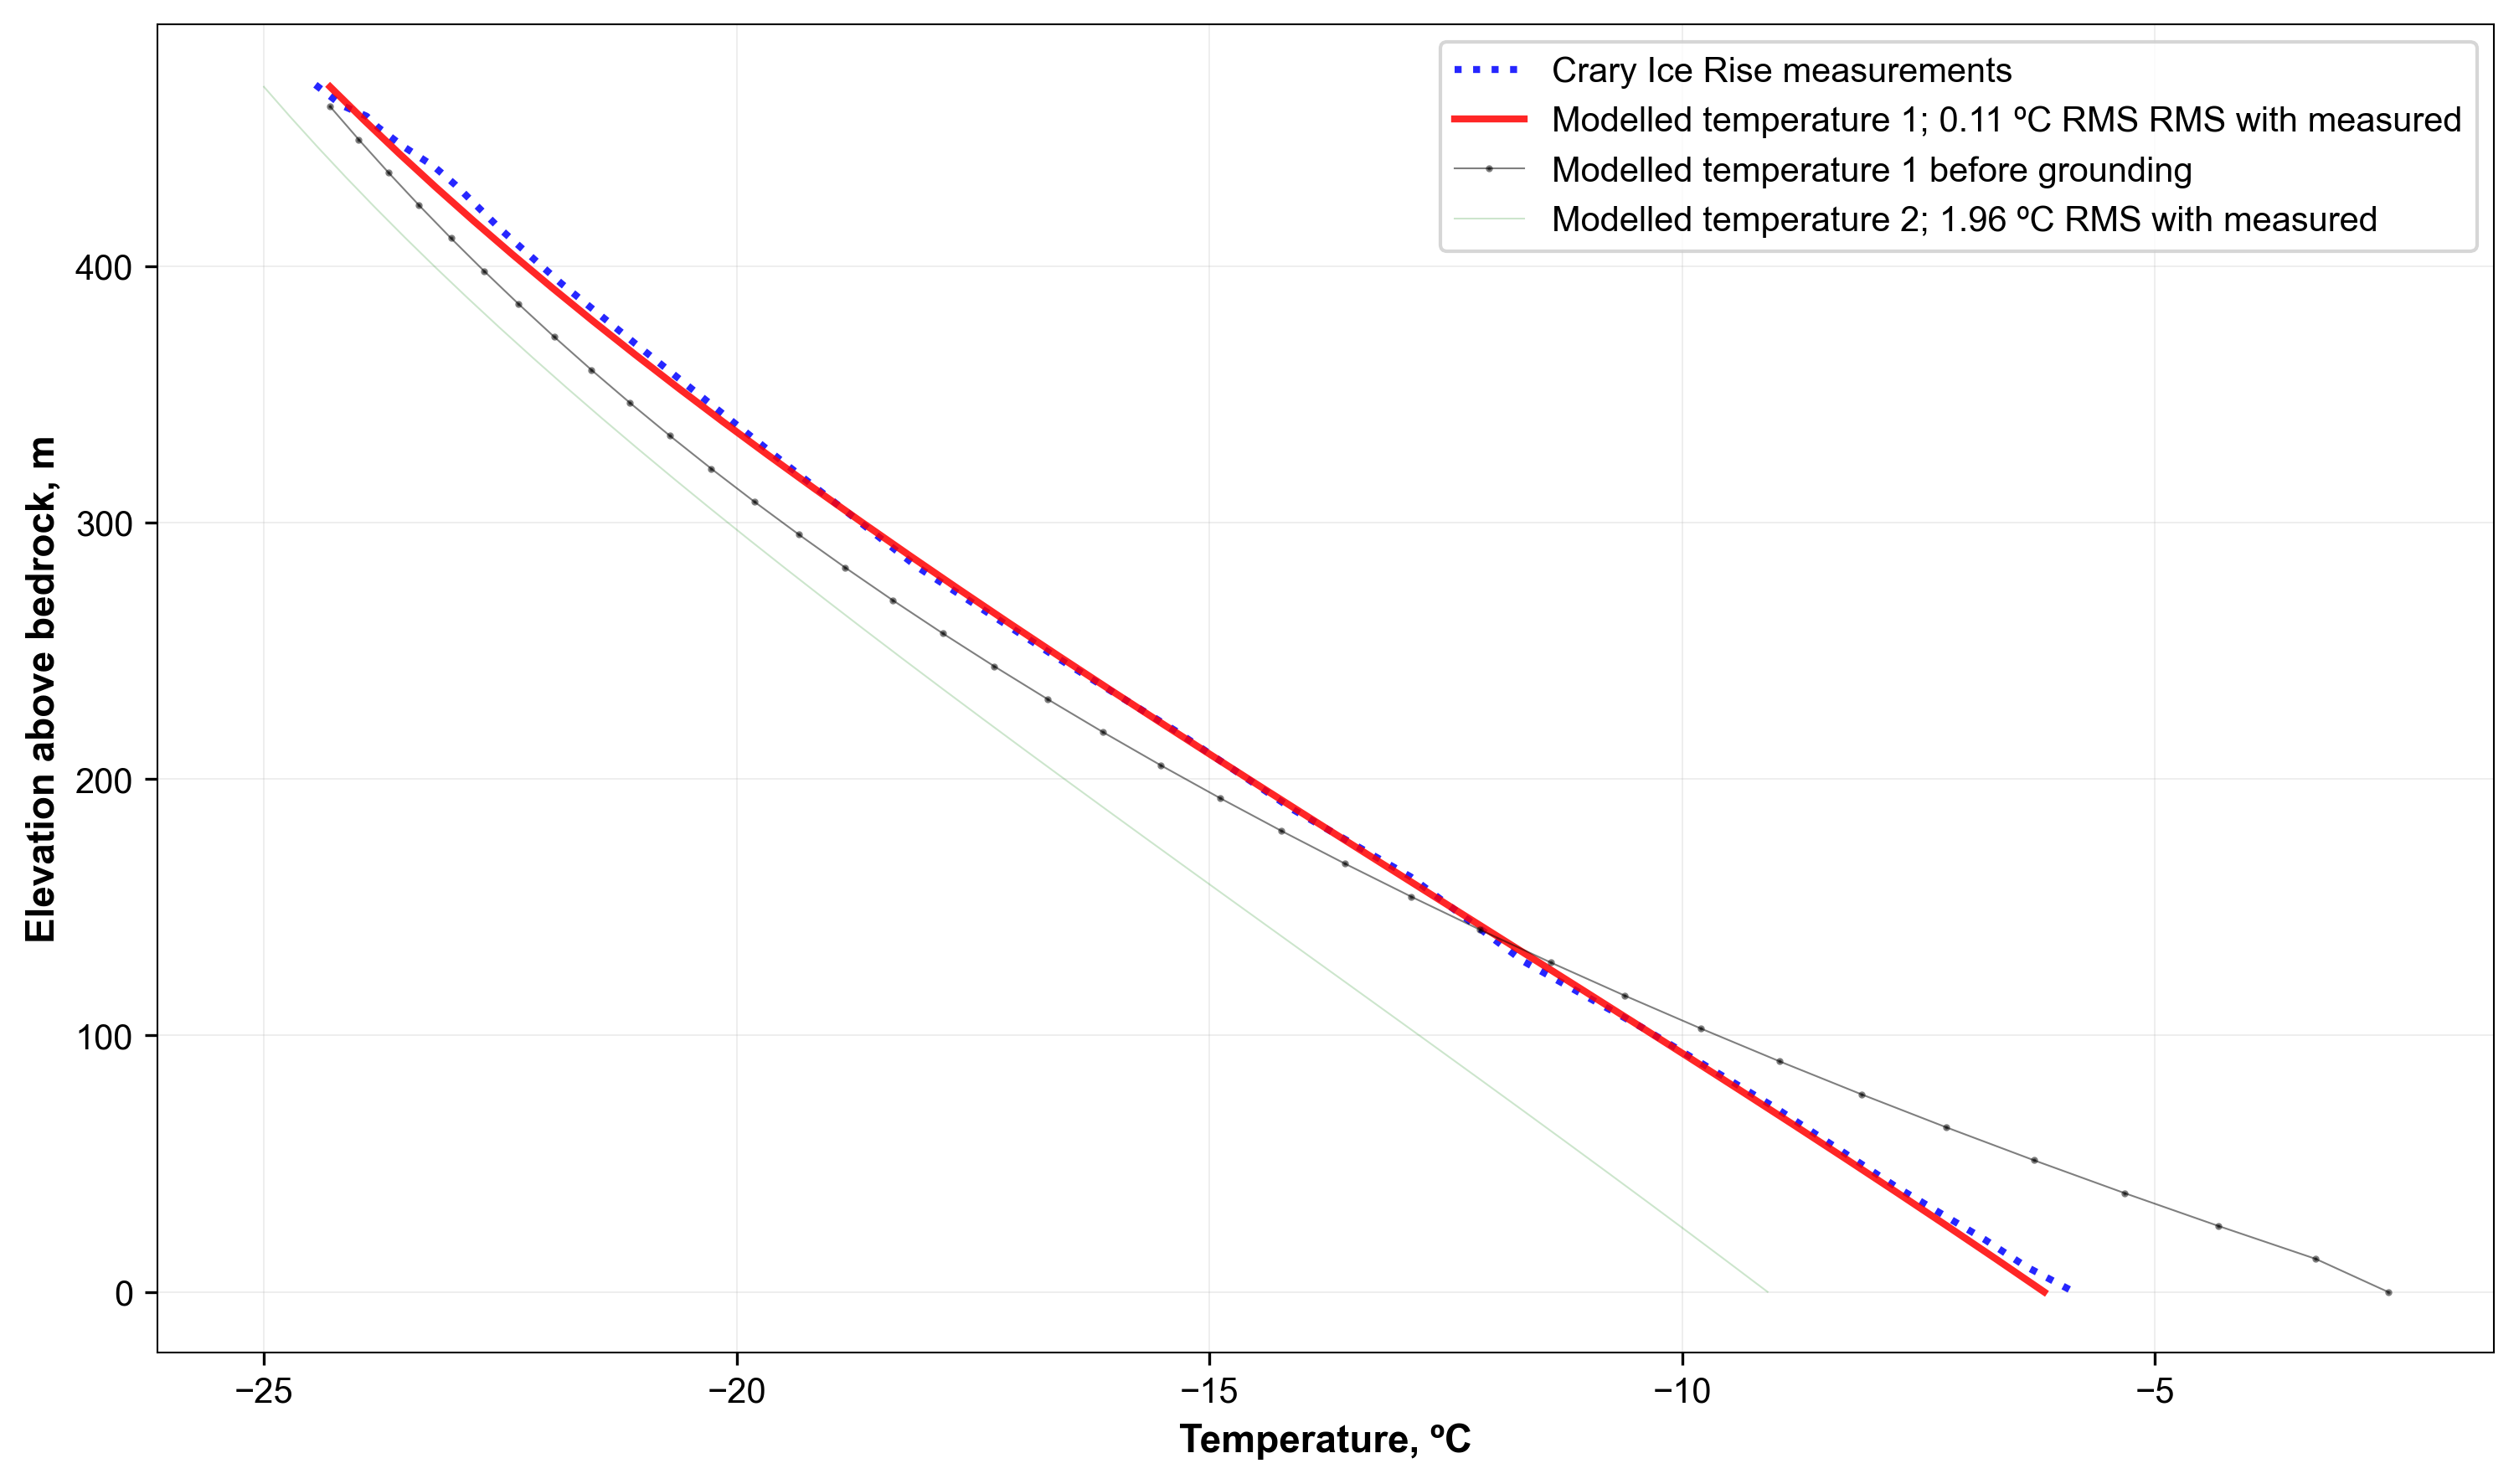

In [13]:
##### Implementing the forward model with some set of prior parameters

Tm_1 = Tmodel([360,470], 500, 10, 5e4, 1e4, 1e4, 7e2, [-24.3, -24.3], [0.11, 0.11], 950e-4)
Tm_2 = Tmodel([400,470], 500, 10, 5e4, 1e4, 1e4, 2e3, [-30, -25], [0.2, 0.1], 700e-4)

##### Importing previously measured temperatures from Bindschadler et al 1991

Bindschadler_Crary_T_profile = np.genfromtxt('Crary Ice RIse borehole measurements from Bindschadler et al 1991/Binschadler_Crary_D_Borehole_Temperatures.csv', delimiter=',', skip_header=1)

### Calculating RMS difference between modelled and calculated profiles

T_interp_Bind = rsmpl(Bindschadler_Crary_T_profile[:,0],Bindschadler_Crary_T_profile[:,1], 10)
T_interp_modelled_1 = rsmpl(Tm_1["Tvar_H_Tmatrix"][:,-1],Tm_1["zvar_H_Tmatrix"][:,-1],10)
T_interp_modelled_2 = rsmpl(Tm_2["Tvar_H_Tmatrix"][:,-1],Tm_2["zvar_H_Tmatrix"][:,-1],10)
RMS_Crary_1 = RMS(T_interp_modelled_1[0],T_interp_Bind[0])
RMS_Crary_2 = RMS(T_interp_modelled_2[0],T_interp_Bind[0])

##### Plotting the results

plt.plot(Bindschadler_Crary_T_profile[:,0],Bindschadler_Crary_T_profile[:,1], 'b:', linewidth=2, alpha=0.85,  label='Crary Ice Rise measurements')
plt.plot(Tm_1["Tvar_H_Tmatrix"][50:,-1],Tm_1["zvar_H_Tmatrix"][50:,-1], 'r', linewidth=2, alpha=0.85, label="Modelled temperature 1; {:0.2f} ºC RMS RMS with measured".format(RMS_Crary_1))
plt.plot(Tm_1["Tvar_H_Tmatrix"][50:,-700],Tm_1["zvar_H_Tmatrix"][50:,-700], 'k.-', linewidth=0.5, alpha=0.5, label="Modelled temperature 1 before grounding")

plt.plot(Tm_2["Tvar_H_Tmatrix"][50:,-1],Tm_2["zvar_H_Tmatrix"][50:,-1], 'g', linewidth=0.5, alpha=0.2, label="Modelled temperature 2; {:0.2f} ºC RMS with measured".format(RMS_Crary_2))
plt.ylabel('Elevation above bedrock, m')
plt.xlabel('Temperature, ºC')
plt.grid()
plt.legend()


##### Restart the code to update the figure quality according to the following figure parameters:

mpl.rcParams['figure.figsize'] = 12, 7
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300

This demo run shows two different temperature profiles produced by the model, one of which (thick red line) has a close match (0.11 ºC root mean squared difference) between modelled and measured (dashed blue line) temperature profiles. Next section will run a series of simulations to explore the general model sensitivity to the parameter values.

#### 


***

#### 

## 4. Forward model sensitivity experiments

In this section, we perform an ensemble of simulations, in which uncertain parameters are perturbed. The resultant temperature profiles are then compared to examine how altering our prior parameters affected the final temperature profiles. Here, we assign thickness, temperature and accumulation to a fixed value. In the paper, we use outputs from large-scale PISM models as an input for our targeted model. Instructions on how to use PISM model outputs can be found [here](https://gallery.pangeo.io/repos/ldeo-glaciology/pangeo-glaciology-examples/04_paleo_PISM.html).

In [8]:
Tmodel_G_low = Tmodel([1750, 1750], 500, 10, 5e4, 2e4, 0, 0, [-30, -30], [0.2, 0.2], 400e-4)
Tmodel_G_med_low = Tmodel([1750, 1750], 500, 10, 5e4, 2e4, 0, 0, [-30, -30], [0.2, 0.2], 500e-4)
Tmodel_G_mean = Tmodel([1750, 1750], 500, 10, 5e4, 2e4, 0, 0, [-30, -30], [0.2, 0.2], 600e-4)
Tmodel_G_med_high = Tmodel([1750, 1750], 500, 10, 5e4, 2e4, 0, 0, [-30, -30], [0.2, 0.2], 700e-4)
Tmodel_G_high = Tmodel([1750, 1750], 500, 10, 5e4, 2e4, 0, 0, [-30, -30], [0.2, 0.2], 800e-4)

In [9]:
Tmodel_T_low = Tmodel([1750, 1750], 500, 10, 5e4, 2e4, 0, 0, [-35, -35], [0.2, 0.2], 600e-4)
Tmodel_T_med_low = Tmodel([1750, 1750], 500, 10, 5e4, 2e4, 0, 0, [-32.5, -32.5], [0.2, 0.2], 600e-4)
Tmodel_T_mean = Tmodel([1750, 1750], 500, 10, 5e4, 2e4, 0, 0, [-30, -30], [0.2, 0.2], 600e-4)
Tmodel_T_med_high = Tmodel([1750, 1750], 500, 10, 5e4, 2e4, 0, 0, [-27.5, -27.5], [0.2, 0.2], 600e-4)
Tmodel_T_high = Tmodel([1750, 1750], 500, 10, 5e4, 2e4, 0, 0, [-25, -25], [0.2, 0.2], 600e-4)

In [10]:
Tmodel_a_low = Tmodel([1750, 1750], 500, 10, 5e4, 2e4, 0, 0, [-30, -30], [0.1, 0.1], 600e-4)
Tmodel_a_med_low = Tmodel([1750, 1750], 500, 10, 5e4, 2e4, 0, 0, [-30, -30], [0.15, 0.15], 600e-4)
Tmodel_a_mean = Tmodel([1750, 1750], 500, 10, 5e4, 2e4, 0, 0, [-30, -30], [0.2, 0.2], 600e-4)
Tmodel_a_med_high = Tmodel([1750, 1750], 500, 10, 5e4, 2e4, 0, 0, [-30, -30], [0.25, 0.25], 600e-4)
Tmodel_a_high = Tmodel([1750, 1750], 500, 10, 5e4, 2e4, 0, 0, [-30, -30], [0.3, 0.3], 600e-4)

In [11]:
Tmodel_t_low = Tmodel([1750, 1750], 500, 10, 4e4, 1e5, 4e4, 5e2, [-30, -30], [0.2, 0.2], 600e-4)
Tmodel_t_med_low = Tmodel([1750, 1750], 500, 10, 4e4, 1e5, 4e4, 1e3, [-30, -30], [0.2, 0.2], 600e-4)
Tmodel_t_mean = Tmodel([1750, 1750], 500, 10, 1e5, 4e4, 4e4, 2e3, [-30, -30], [0.2, 0.2], 600e-4)
Tmodel_t_med_high = Tmodel([1750, 1750], 500, 10, 4e4,  1e5, 4e4, 4e3, [-30, -30], [0.2, 0.2], 600e-4)
Tmodel_t_high = Tmodel([1750, 1750], 500, 10, 4e4, 1e5, 4e4, 8e3, [-30, -30], [0.2, 0.2], 600e-4)

Text(0.5, 1.0, 'Sensitivity to surface temperature')

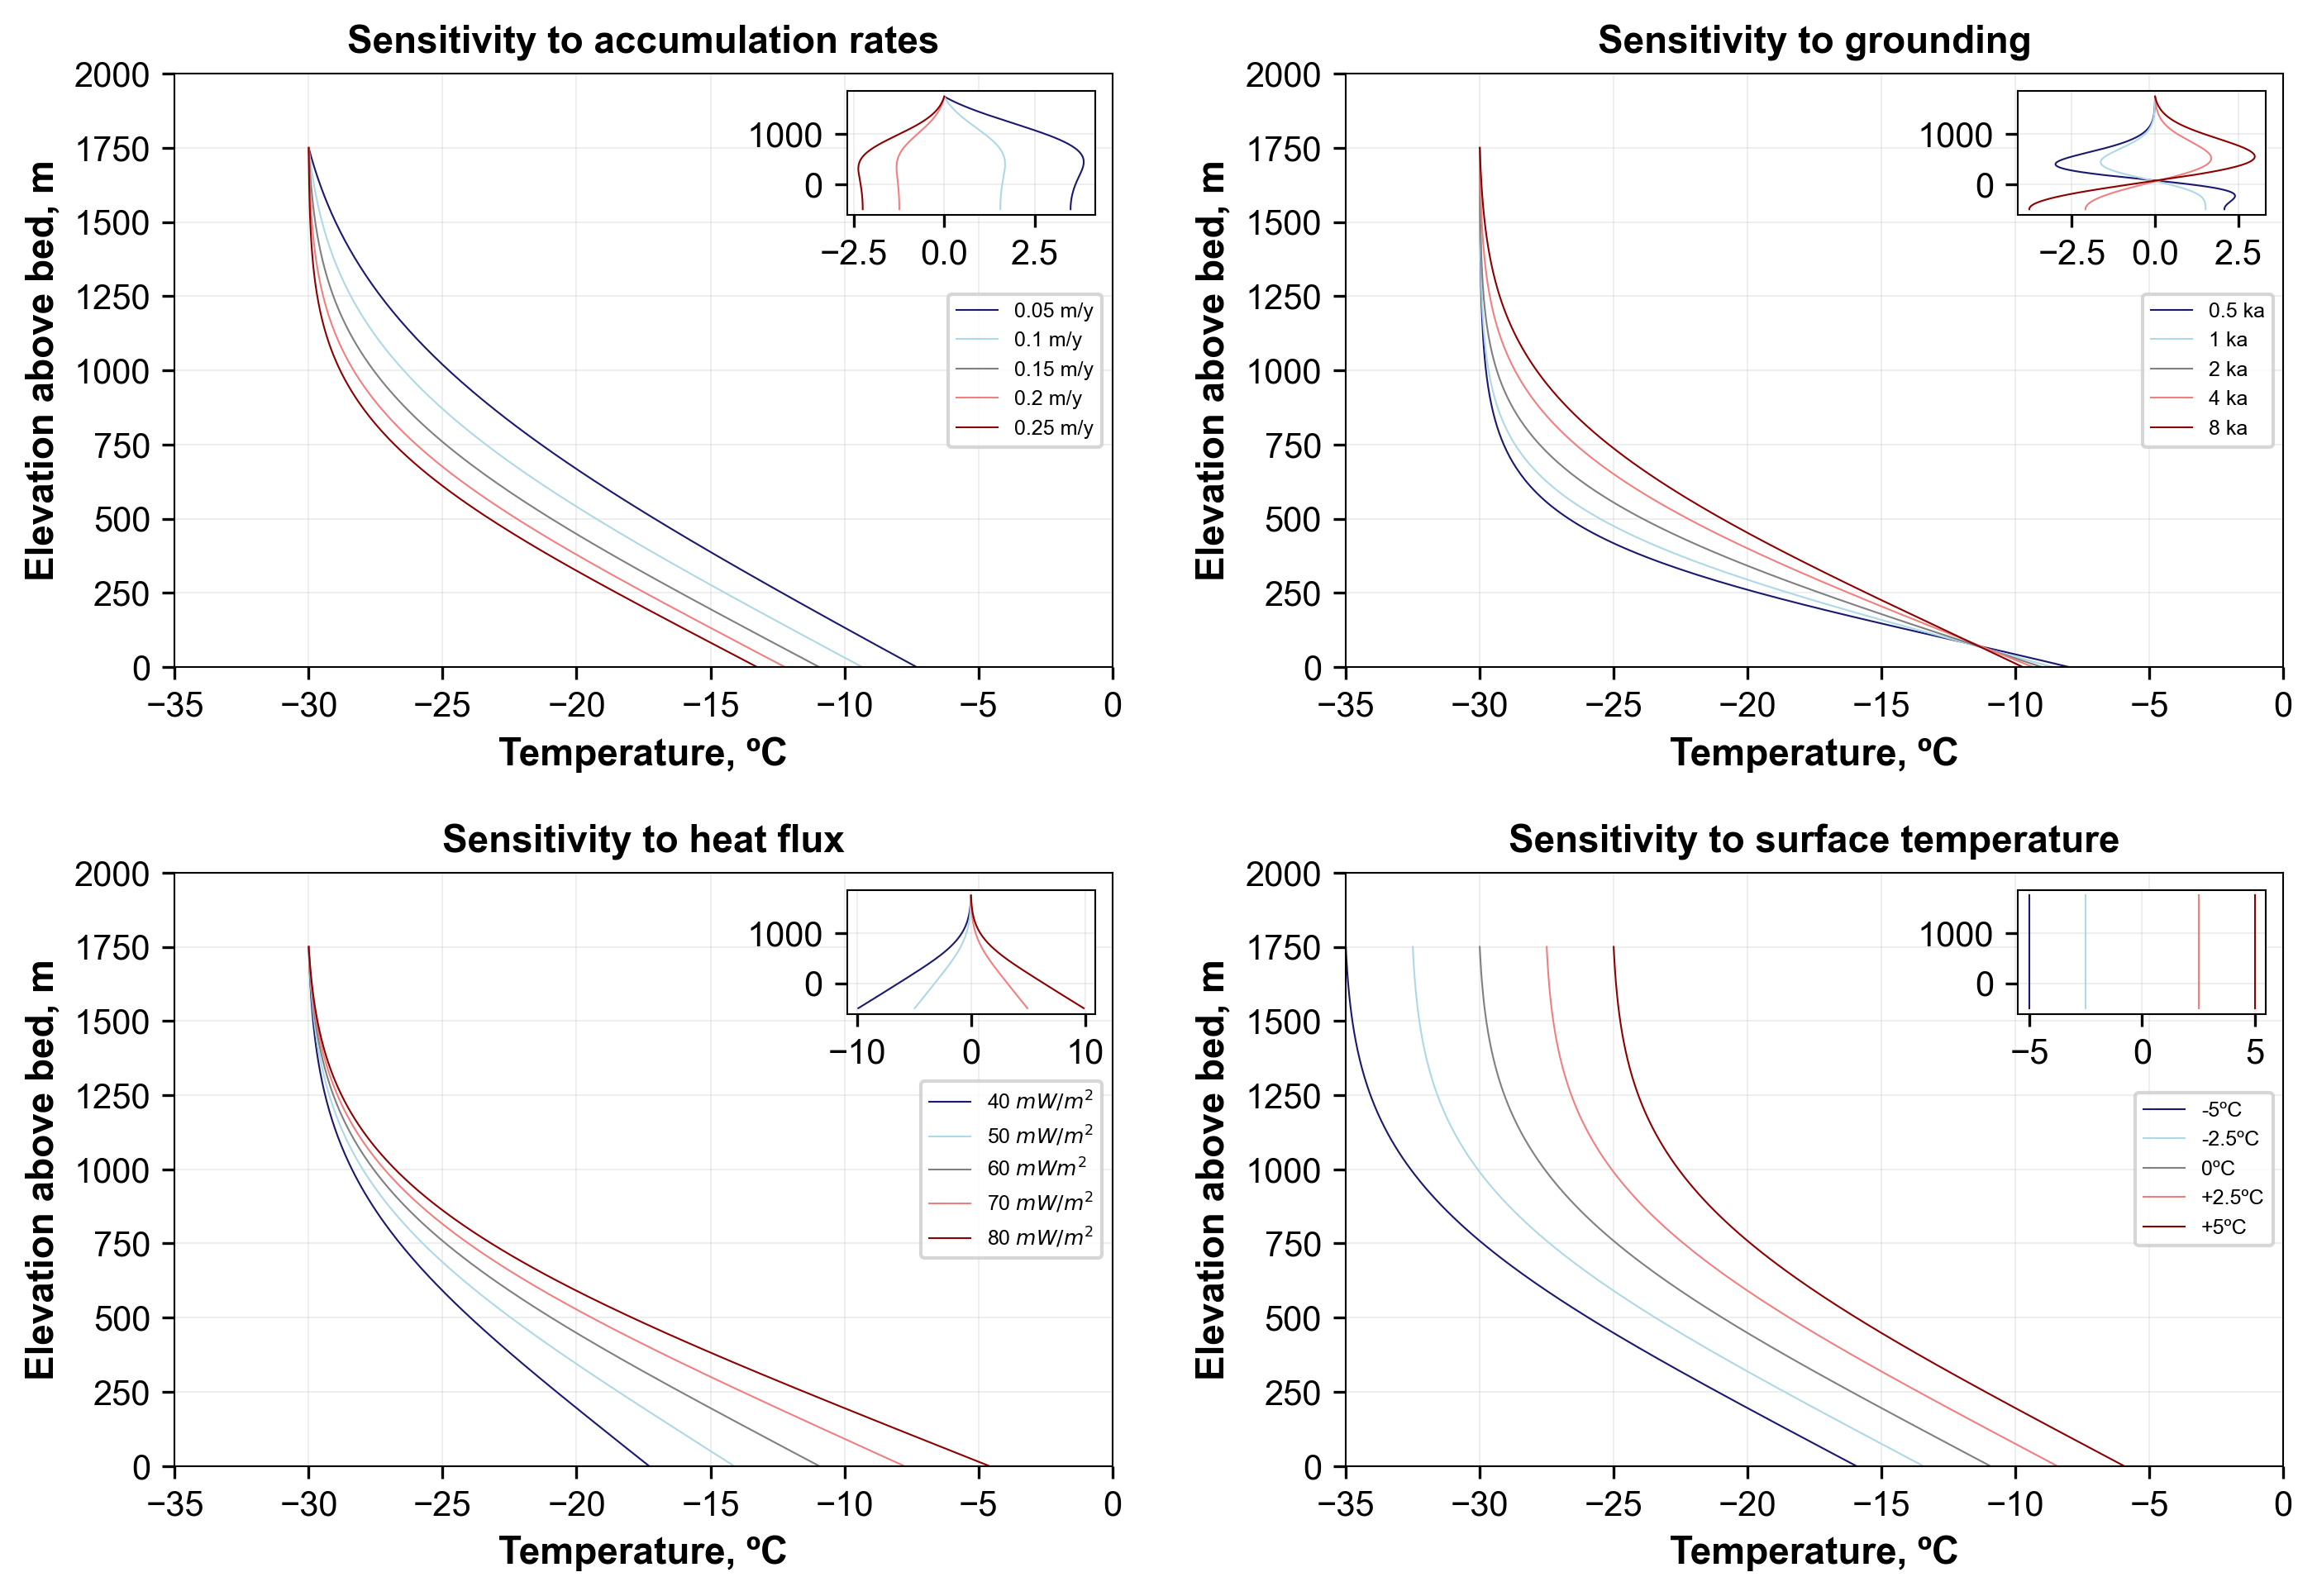

In [12]:
fig, ax = plt.subplots(figsize=(10, 7), ncols=2, nrows = 2)
fig.tight_layout(pad=4.0)

z =  Tmodel_G_mean["zvar_H_Tmatrix"]


ax[0,0].plot(Tmodel_a_low["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'midnightblue',label='0.05 m/y', linewidth=0.5)
ax[0,0].plot(Tmodel_a_med_low["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'lightblue',label='0.1 m/y', linewidth=0.5)
ax[0,0].plot(Tmodel_a_mean["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'grey',label='0.15 m/y', linewidth=0.5)
ax[0,0].plot(Tmodel_a_med_high["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'lightcoral',label='0.2 m/y', linewidth=0.5)
ax[0,0].plot(Tmodel_a_high["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'darkred',label='0.25 m/y', linewidth=0.5)
# ax[0,0].axhline(0, color='k', linestyle='-', linewidth=0.5)
# ax[0,0].axhspan(min(z), 0, facecolor='k', alpha=0.02)
# ax[0,0].axhspan(0, max(z), facecolor='b', alpha=0.02)
ax[0,0].legend(loc='center right',prop={'size': 6})
ax[0,0].set_xlabel('Temperature, ºC')
ax[0,0].set_ylabel('Elevation above bed, m')
# ax[0,0].set_title('Sensitivity to accumulation')
axins = inset_axes(ax[0, 0], width=1.0, height=0.5, loc='upper right')
axins.plot(-Tmodel_a_mean["Tvar_H_Tmatrix"][:,-1]+Tmodel_a_low["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'midnightblue',label='Low - mean', linewidth=0.5)
axins.plot(-Tmodel_a_mean["Tvar_H_Tmatrix"][:,-1]+Tmodel_a_med_low["Tvar_H_Tmatrix"][:,-1],z[:,-1], 'lightblue',label='Med low - mean', linewidth=0.5)
axins.plot(-Tmodel_a_mean["Tvar_H_Tmatrix"][:,-1]+Tmodel_a_med_high["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'lightcoral',label='Med high - mean', linewidth=0.5)
axins.plot(-Tmodel_a_mean["Tvar_H_Tmatrix"][:,-1]+Tmodel_a_high["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'darkred',label='High - mean', linewidth=0.5)
axins.grid()
ax[0,0].grid()
ax[0,0].set_xlim((-35, 0))
ax[0,0].set_ylim((0, 2000))
ax[0,0].set_title('Sensitivity to accumulation rates')


ax[0,1].plot(Tmodel_t_low["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'midnightblue',label='0.5 ka', linewidth=0.5)
ax[0,1].plot(Tmodel_t_med_low["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'lightblue',label='1 ka', linewidth=0.5)
ax[0,1].plot(Tmodel_t_mean["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'grey',label='2 ka', linewidth=0.5)
ax[0,1].plot(Tmodel_t_med_high["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'lightcoral',label='4 ka', linewidth=0.5)
ax[0,1].plot(Tmodel_t_high["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'darkred',label='8 ka', linewidth=0.5)
# ax[0,0].axhline(0, color='k', linestyle='-', linewidth=0.5)
# ax[0,0].axhspan(min(z), 0, facecolor='k', alpha=0.02)
# ax[0,0].axhspan(0, max(z), facecolor='b', alpha=0.02)
ax[0,1].legend(loc='center right',prop={'size': 6})
ax[0,1].set_xlabel('Temperature, ºC')
ax[0,1].set_ylabel('Elevation above bed, m')
# ax[0,0].set_title('Sensitivity to accumulation')
axins = inset_axes(ax[0, 1], width=1.0, height=0.5, loc='upper right')
axins.plot(-Tmodel_t_mean["Tvar_H_Tmatrix"][:,-1]+Tmodel_t_low["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'midnightblue',label='Low - mean', linewidth=0.5)
axins.plot(-Tmodel_t_mean["Tvar_H_Tmatrix"][:,-1]+Tmodel_t_med_low["Tvar_H_Tmatrix"][:,-1],z[:,-1], 'lightblue',label='Med low - mean', linewidth=0.5)
axins.plot(-Tmodel_t_mean["Tvar_H_Tmatrix"][:,-1]+Tmodel_t_med_high["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'lightcoral',label='Med high - mean', linewidth=0.5)
axins.plot(-Tmodel_t_mean["Tvar_H_Tmatrix"][:,-1]+Tmodel_t_high["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'darkred',label='High - mean', linewidth=0.5)
axins.grid()
ax[0,1].grid()
ax[0,1].set_xlim((-35, 0))
ax[0,1].set_ylim((0, 2000))
ax[0,1].set_title('Sensitivity to grounding')


ax[1,0].plot(Tmodel_G_low["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'midnightblue',label='40 ${mW/m^2}$', linewidth=0.5)
ax[1,0].plot(Tmodel_G_med_low["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'lightblue',label='50 ${mW/m^2}$', linewidth=0.5)
ax[1,0].plot(Tmodel_G_mean["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'grey',label='60 ${mW m^2}$', linewidth=0.5)
ax[1,0].plot(Tmodel_G_med_high["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'lightcoral',label='70 ${mW/m^2}$', linewidth=0.5)
ax[1,0].plot(Tmodel_G_high["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'darkred',label='80 ${mW/m^2}$', linewidth=0.5)
ax[1,0].legend(loc='center right',prop={'size': 6})
ax[1,0].set_xlabel('Temperature, ºC')
ax[1,0].set_ylabel('Elevation above bed, m')
axins = inset_axes(ax[1, 0], width=1.0, height=0.5, loc='upper right')
axins.plot(-Tmodel_G_mean["Tvar_H_Tmatrix"][:,-1]+Tmodel_G_low["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'midnightblue',label='Low - mean', linewidth=0.5)
axins.plot(-Tmodel_G_mean["Tvar_H_Tmatrix"][:,-1]+Tmodel_G_med_low["Tvar_H_Tmatrix"][:,-1],z[:,-1], 'lightblue',label='Med low - mean', linewidth=0.5)
axins.plot(-Tmodel_G_mean["Tvar_H_Tmatrix"][:,-1]+Tmodel_G_med_high["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'lightcoral',label='Med high - mean', linewidth=0.5)
axins.plot(-Tmodel_G_mean["Tvar_H_Tmatrix"][:,-1]+Tmodel_G_high["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'darkred',label='High - mean', linewidth=0.5)
axins.grid()
ax[1,0].grid()
ax[1,0].set_xlim((-35, 0))
ax[1,0].set_ylim((0, 2000))
ax[1,0].set_title('Sensitivity to heat flux')

ax[1,1].plot(Tmodel_T_low["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'midnightblue',label='-5ºC', linewidth=0.5)
ax[1,1].plot(Tmodel_T_med_low["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'lightblue',label='-2.5ºC', linewidth=0.5)
ax[1,1].plot(Tmodel_T_mean["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'grey',label='0ºC', linewidth=0.5)
ax[1,1].plot(Tmodel_T_med_high["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'lightcoral',label='+2.5ºC', linewidth=0.5)
ax[1,1].plot(Tmodel_T_high["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'darkred',label='+5ºC', linewidth=0.5)
ax[1,1].legend(loc='center right',prop={'size': 6})
ax[1,1].set_xlabel('Temperature, ºC')
ax[1,1].set_ylabel('Elevation above bed, m')
axins = inset_axes(ax[1, 1], width=1.0, height=0.5, loc='upper right')
axins.plot(-Tmodel_T_mean["Tvar_H_Tmatrix"][:,-1]+Tmodel_T_low["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'midnightblue',label='Low - mean', linewidth=0.5)
axins.plot(-Tmodel_T_mean["Tvar_H_Tmatrix"][:,-1]+Tmodel_T_med_low["Tvar_H_Tmatrix"][:,-1],z[:,-1], 'lightblue',label='Med low - mean', linewidth=0.5)
axins.plot(-Tmodel_T_mean["Tvar_H_Tmatrix"][:,-1]+Tmodel_T_med_high["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'lightcoral',label='Med high - mean', linewidth=0.5)
axins.plot(-Tmodel_T_mean["Tvar_H_Tmatrix"][:,-1]+Tmodel_T_high["Tvar_H_Tmatrix"][:,-1], z[:,-1], 'darkred',label='High - mean', linewidth=0.5)
axins.grid()
ax[1,1].grid()
ax[1,1].set_xlim((-35, 0))
ax[1,1].set_ylim((0, 2000))
ax[1,1].set_title('Sensitivity to surface temperature')


This sensitivity run shows how perturbing some of the key parameters reflects on the shape of temperature profile through an ice column. Other experiments presented in the paper but not featured in this notebook involve changing the vertical velocity profiles according to Eqs. (3)-(7), as well as introducing time-variable surface temperature, accumulation and thickness. All these experiments can be ran in a similar way as the models presented above.

#### 


***

#### 

## 5. Borehole temperature inversion

In this section, we perform inversion of englacial borehole measurements. We implement Markov Chain Monte Carlo methods using [*Emcee*](https://emcee.readthedocs.io/en/stable/), a Python-based software package which implements the affine-invariant ensemble sampler. More details about this method can be found in the articles by [Goodman and Weare, 2010](https://msp.org/camcos/2010/5-1/p04.xhtml) and [Foreman-Mackey et al., 2014](https://iopscience.iop.org/article/10.1086/670067/meta).

The Markov Chain Monte Carlo (MCMC) method tests randomly selected combinations of prior variables using a random walk through a high-dimensional parameter space. The variables are assumed to be ‘unknown’ parameters and are prescribed prior distributions (or simply a range of realistic prior values). The forward model uses these parameters from their prior distributions as inputs, and its output is compared to the measured (or synthetic) temperature profiles. In each step of random walk with predefined length, a perturbed model of the current model is proposed. The MCMC then uses a likelihood function **L** to estimate the agreement between the modelled and measured profiles:


\begin{equation}
  \label{eq:Ln}
  L = -\frac{1}{2} \sum{\left(\frac{T_{data}-T_{model}}{T_{error}}\right)^{2}}
  \;, \tag{8}
\end{equation}


where **Tdata** and **Tmodel** are the measured and predicted temperatures for each point of the grid, and **Terror** is the uncertainty of measurements.

### 5.1 Running simple inversion with synthetic 'measured' temperature profile

We begin with validating our inverse model. To do that, we produce a synthetic 'measurement' using the forward model described in previous section. We choose a hypothetical 1-km thick ice sheet and 500-m thick bedrock below:

In [14]:
Hr = 500
Hi = 1000
dz = 10
z = np.linspace(-int(Hr), int(Hi), int((Hi+Hr)/dz) + 1)   # Space calculation domain for ice and rock
zi = np.linspace(0, Hi, int(Hi/dz) + 1)  # Space calculation domain for ice
zr = np.linspace(-Hr, 0, int(Hr/dz) + 1) #  Space calculation domain for rock
l = len(zr)  # Index for ice-bed interface to be used in the loop calculations
Lz = len(z)  # Number of elements in space domain
Lzi = len(zi) #  Number of elements in space domain for ice
Lzr = len(zr) #  Number of elements in space domain for ice

Now we need to define a (forward) model that will be used in inversion and that will take input parameters and yield results that are then compared to the 'measured' (in this case, synthetic) temperature profiles. In this case our model takes two arguments: **theta** (which is a set of our unknown variables) and spatial domain **z**, defined above. 

The function below is a simplified version of the function defined in the previous section:

In [15]:
def model_synthetic(theta, z):
    
    t_grounding, G, a_yr, T_sim = theta
    a = a_yr/yr_to_s
    
    dzr = dz
    
    Ts_surf_steady = T_sim
    Ts = -z*0 + Ts_surf_steady

    for i in range(1, int(15e3)):

        # Ice shelf vertical velocity profile

        w = -np.linspace(0,a,Lzi) # Linear vertical velocity profile for floating ice (accumulation is not balanced by melting/freezing)

        # Above ice-rock interface

        Ts[l:-1] = Ts[l:-1] + dt*(alpha_i*(Ts[l+1:]-2*Ts[l:-1]+Ts[l-1:-2])/dz**2 - np.multiply(w[1:-1],(Ts[l+1:]-Ts[l-1:-2])/(2*dz)))
        Ts[-1] = Ts_surf_steady # Temperature forcing is constant and equals the first value of the imported Monte-Carlo surface temperature vectors

        Ts[l-1] = -2

        # Below ice-rock interface

        Ts[1:l-1] = Ts[1:l-1] + dt*alpha_r*(Ts[2:l]-2*Ts[1:l-1]+Ts[0:l-2])/dz**2
        Ts[0] = Ts[1] + (G/k_r*dz)

        # Recording the result into an empty matrix for comparison
    
    for j in range(0, int(t_grounding)):

        # Grounded ice vertical velocity profile

        dws = a  # -((Hi(jj) - Hi(jj - 1)) / dt); # When thickness is variable through time
        wzt = (1 - (((n + 2) / (n + 1)) * (1 - zi / Hi)) + (1 / (n + 1)) * np.power((1 - zi / Hi), (n + 2)))
        ws = -dws * wzt

        # Above ice-rock interface

        Ts[l:-1] = Ts[l:-1] + dt*(alpha_i*(Ts[l+1:]-2*Ts[l:-1]+Ts[l-1:-2])/dz**2 - np.multiply(ws[1:-1],(Ts[l+1:]-Ts[l-1:-2])/(2*dz)))
        Ts[-1] = T_sim

        # Below ice-rock interface

        Ts[1:l] = Ts[1:l] + dt * alpha_r * (Ts[2:l+1]-2*Ts[1:l]+Ts[0:l-1])/dzr**2
        Ts[0] = Ts[1] + (G/k_r*dzr)

    return Ts[l-1:]

The function above is then used to produce synthetic borehole 'measurements':

In [16]:
Tsteady_ice_shelf = model_synthetic([0, 0.050, 0.1, -30],z)
Tmeasured = model_synthetic([1000, 0.050, 0.1, -30],z)

Everything is now ready for executing inversion using emcee module. It is computationally expensive and takes several hours to finish on MBP with M1 chip:

In [ ]:
%%time  

def lnlike(theta, x, y, yerr): # Defining the likelihood function (Eq. (9))
    return -0.5 * np.sum(((y - model_synthetic(theta, x))/yerr) ** 2)


def lnprior(theta): # Defining the range of possible prior values for unknown parameters
    t_grounding, G, a_yr, T_sim = theta
    if 0 < t_grounding < 10000  and 0 < G < 0.150 and 0 < a_yr < 2.0 and -50 < T_sim < -10:
        return 0.0
    return -np.inf


def lnprob(theta,x, y, yerr): 
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)


Terr = 0.05*np.mean(Tmeasured) # Defining the measurement error
data = (z,Tmeasured,Terr) # Defining the original measurements to be inverted for
nwalkers = 256 # Defining the number of walkers in the parameter space
niter = 512  # Defining the number of iterations in the parameter space for each walker
initial = np.array([500, 0.040, 0.5, -40]) # Defining the initial parameter values as a starting point for inversion
ndim = len(initial)
p0 = [np.array(initial) + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)] # Defining the random walk method of stepping within the parameter space from one set of values to another

def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data, pool=pool)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

# Setting parallel simulation to save computation time
if __name__ == '__main__':
    mp.set_start_method('fork', force=True)

with Pool() as pool:
    sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

# The sampler contains all the outputs of the MCMC inversion, including the walker chains and the posteriors
samples = sampler.flatchain # Saving every sample
probability = sampler.flatlnprobability # Saving corresponding probabilities (i.e., match between measured and modelled data)

# Saving these data as text files:

# np.savetxt('synthetic_samples_fixed_Temp_a_G__tgrounding_inversion_{walkers}_walkers_{iterations}_iterations_{parameters}_{Hi}_{Hr}.csv'.format(walkers=nwalkers, iterations = niter, parameters = initial, Hi = Hi, Hr = Hr), samples, delimiter=',')
# np.savetxt('synthetic_probabilities_fixed_Temp_a_G__tgrounding_inversion_{walkers}_walkers_{iterations}_iterations_{parameters}_{Hi}_{Hr}.csv'.format(walkers=nwalkers, iterations = niter, parameters = initial,  Hi = Hi, Hr = Hr), probability, delimiter=',')

Running burn-in...


Preparing data for plotting and calculating RMS for a subset of samples:

CPU times: user 11min 51s, sys: 9.3 s, total: 12min
Wall time: 11min 55s


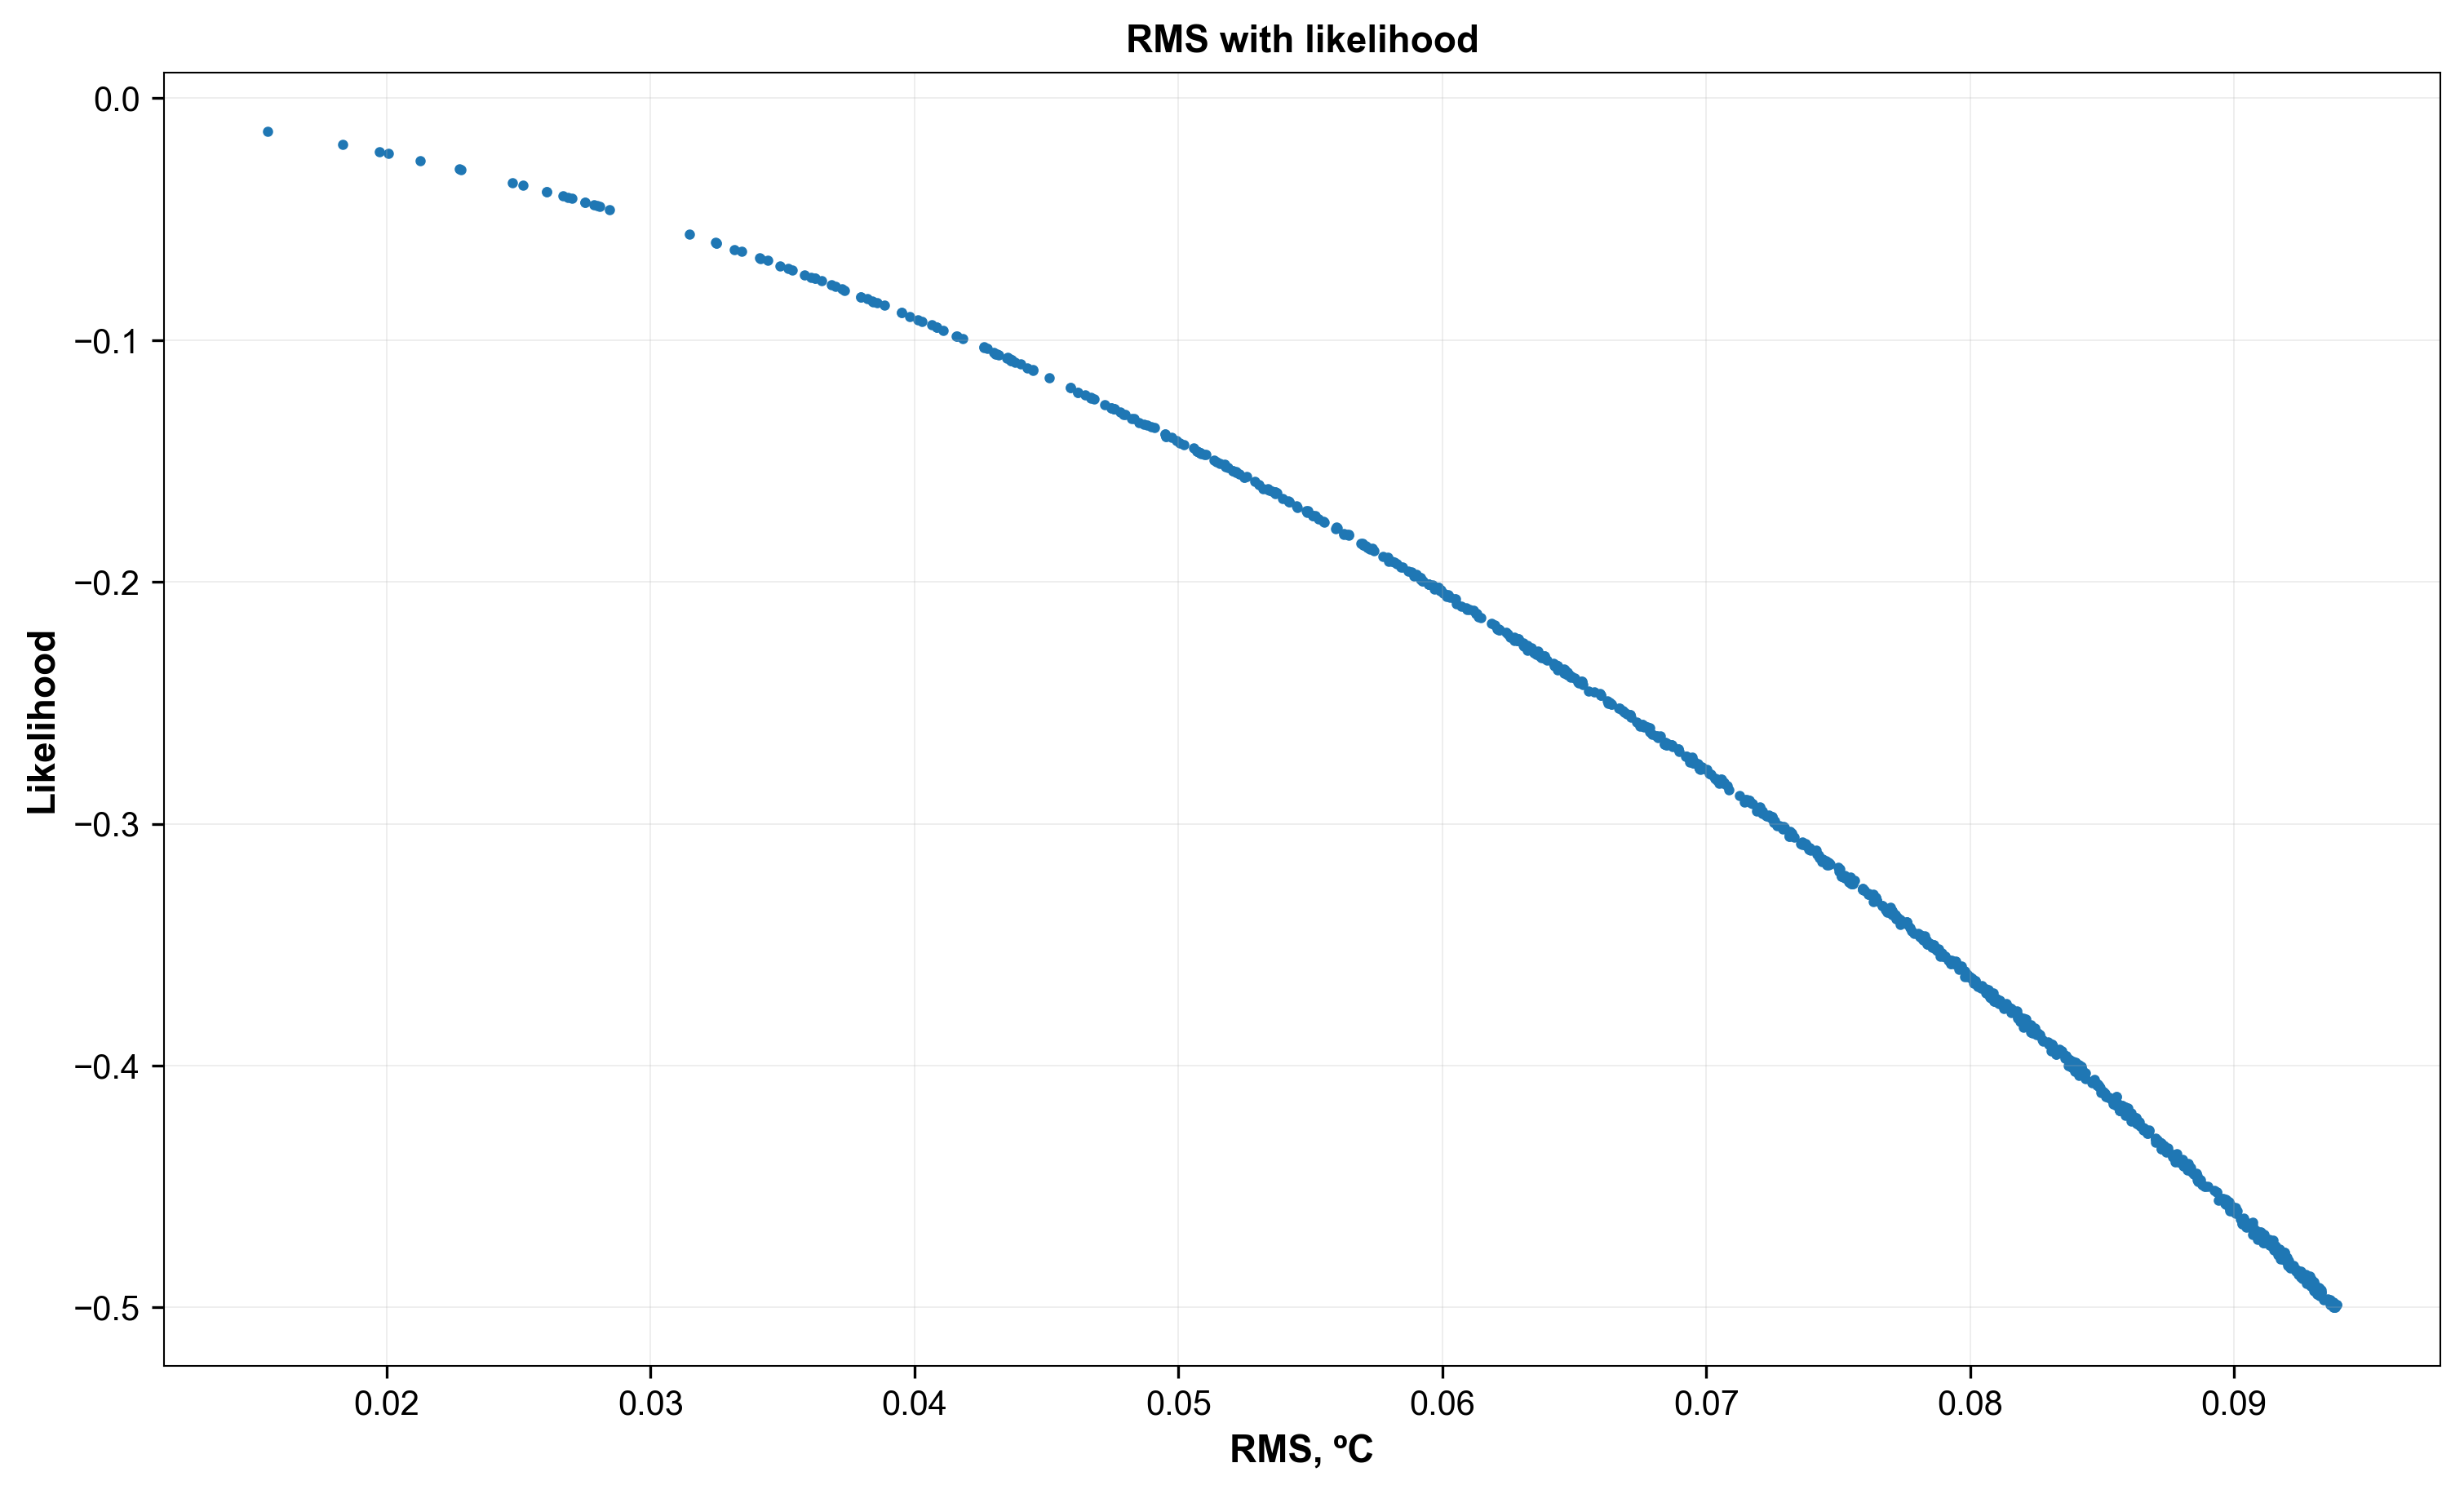

In [17]:
%%time

samples = np.loadtxt('Inversion MCMC sampling results/synthetic_samples_fixed_Temp_a_G__tgrounding_inversion_256_walkers_512_iterations_[ 5.e+02  3.e-02  1.e+00 -4.e+01]_1000_500.csv', delimiter=',')
probabilities = np.loadtxt('Inversion MCMC sampling results/synthetic_probabilities_fixed_Temp_a_G__tgrounding_inversion_256_walkers_512_iterations_[ 5.e+02  3.e-02  1.e+00 -4.e+01]_1000_500.csv', delimiter=',')


lnprobmax = -0.5
lnprobmin = -2.5

probmax = np.array(probabilities[(probabilities>lnprobmax)])

# Taking a sample

index = np.random.randint(len(samples[(probabilities>lnprobmax)]), size=1000)

# Retrieving inversion parameters from the MCMC sampler

xs1 = np.array(samples[(probabilities>lnprobmax)][:,0])[index]
ys1 = np.array(samples[(probabilities>lnprobmax)][:,1])[index]
zs1 = np.array(samples[(probabilities>lnprobmax)][:,2])[index]
ts1 = np.array(samples[(probabilities>lnprobmax)][:,3])[index]
xs = np.array(samples[(probabilities>lnprobmin)][:,0])
ys = np.array(samples[(probabilities>lnprobmin)][:,1])
zs = np.array(samples[(probabilities>lnprobmin)][:,2])
ts = np.array(samples[(probabilities>lnprobmin)][:,3])


# Calculating RMS for best fit data


rmslik = [] 
for i in range (0,len(index)):
    rmslik.append(RMS(model_synthetic(samples[(probabilities>lnprobmax)][index[i]], z), Tmeasured))

    
plt.scatter(rmslik, probmax[index]) # Plotting the relation between likelihood value and RMS between measured and simulated temperature profiles
plt.xlabel('RMS, ºC')
plt.ylabel('Likelihood')
plt.title('RMS with likelihood')
plt.grid()

Plotting the inversion results:

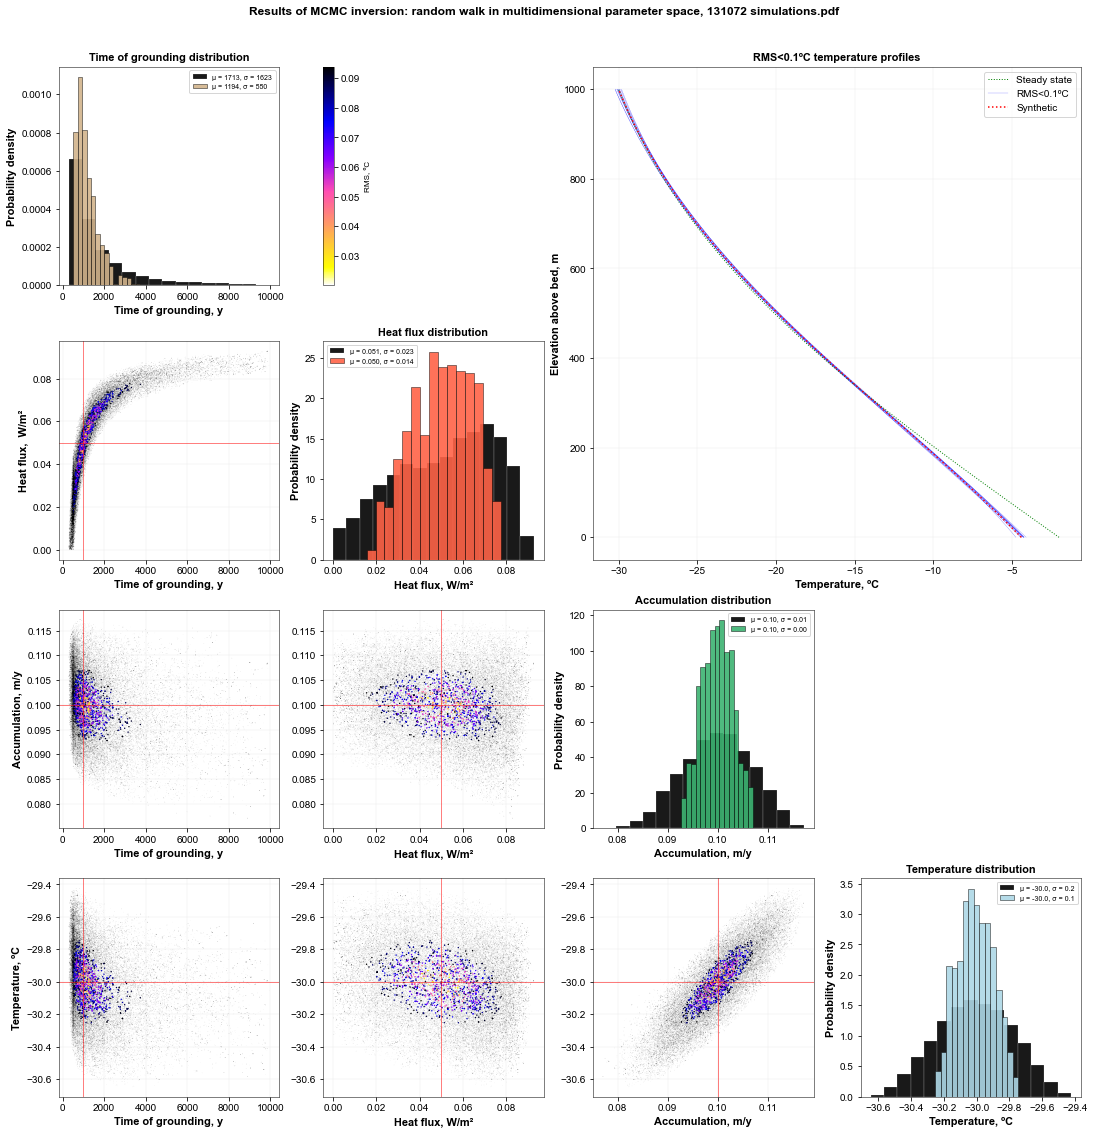

CPU times: user 32.5 s, sys: 1.89 s, total: 34.4 s
Wall time: 31.6 s


In [158]:
%%time

# mpl.rcParams['figure.dpi'] = 200

fig = plt.figure(figsize=(15, 15), constrained_layout=True)

# fig, ax = plt.subplots(figsize=(15, 15), ncols=4, nrows = 4)
fig.tight_layout(pad=2.0)

fig.suptitle('Results of MCMC inversion: random walk in multidimensional parameter space, {:0.0f} simulations.pdf'.format(len(samples)), y=1.04)

gs = GridSpec(4, 4, figure=fig)


ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(xs, 15, density=True, facecolor='black', edgecolor='white', alpha=0.9, linewidth=0.2, label = "\u03bc = {:0.0f}, \u03C3 = {:0.0f}".format(np.mean(xs),np.std(xs)))
ax1.hist(xs1, 15, density=True, facecolor='tan', edgecolor='black', alpha=0.9, linewidth=0.5, label = "\u03bc = {:0.0f}, \u03C3 = {:0.0f}".format(np.mean(xs1),np.std(xs1)))
ax1.set_xlabel('Time of grounding, y')
ax1.set_ylabel('Probability density')
ax1.set_title('Time of grounding distribution')
ax1.legend(borderpad=0.5,prop={'size':7})


ax2 = fig.add_subplot(gs[0:2, 2:4])
# for theta in (samples[(probabilities>lnprobmin)])[np.random.randint(len(samples[(probabilities>lnprobmin)]), size=10)]:
#     ax2.plot(model_synthetic(theta, z), z[l-1:], 'k', linewidth=0.25, alpha=0.1)
# ax2.plot(model_synthetic(theta, z), z[l-1:], 'b', linewidth=0.25, alpha=0.25, label = '{:0.2f} fit'.format(lnprobmin))
for theta in (samples[(probabilities>lnprobmax)])[np.random.randint(len(samples[(probabilities>lnprobmax)]), size=10)]:
    ax2.plot(model_synthetic(theta, z), z[l-1:], 'b', linewidth=0.25, alpha=0.7)
ax2.plot(Tsteady_ice_shelf, z[l-1:], 'g:', linewidth=1, label='Steady state')
# ax2.plot(model_synthetic(theta, z), z[l-1:], 'b', linewidth=0.25, alpha=0.7, label = '{:0.2f} fit'.format(lnprobmax))
ax2.plot(model_synthetic(theta, z), z[l-1:], 'b', linewidth=0.25, alpha=0.7, label = 'RMS<0.1ºC')
ax2.plot(Tmeasured, z[l-1:],'r:', linewidth=1.5,  label='Synthetic')
ax2.set_xlabel('Temperature, ºC')
ax2.set_ylabel('Elevation above bed, m')
ax2.grid(linestyle='-', linewidth=0.1)
ax2.legend()
# ax2.set_title('{:0.2f} Likelihood fit and {:0.2f} fit temperature profiles'.format(lnprobmax,lnprobmin))
ax2.set_title('RMS<0.1ºC temperature profiles')


ax3 = fig.add_subplot(gs[1, 0])
pc0 = ax3.scatter(xs, ys,c= 'k', s = 0.5, alpha=0.05,edgecolors='none', cmap='gnuplot2_r')
pc0 = ax3.scatter(xs1, ys1,c = rmslik, s = 2, alpha=1,edgecolors='none', cmap='gnuplot2_r')
ax3.axhline(0.05, color='r', linestyle='-', linewidth=0.5)
ax3.axvline(1000, color='r', linestyle='-', linewidth=0.5)
# ax[0].axhspan(0.040, 0.060, facecolor='r', alpha=0.05)
ax3.grid(linestyle='-', linewidth=0.1)
ax3.set_xlabel('Time of grounding, y')
ax3.set_ylabel('Heat flux,  W/m²')
# fig.colorbar(pc0, ax=ax[2,0]).set_label('Accumulation, m y⁻¹',weight = 'light',size = 8)
# ax3.legend()

ax4 = fig.add_subplot(gs[2, 0])
pc1 = ax4.scatter(xs, zs, c = 'k', s = 0.5, alpha=0.05, edgecolors='none',cmap='gnuplot2_r')
pc1 = ax4.scatter(xs1, zs1,c = rmslik, s = 2, alpha=1,edgecolors='none',cmap='gnuplot2_r')
ax4.grid(linestyle='-', linewidth=0.1)
ax4.axhline(0.1, color='r', linestyle='-', linewidth=0.5)
ax4.axvline(1000, color='r', linestyle='-', linewidth=0.5)
ax4.set_xlabel('Time of grounding, y')
ax4.set_ylabel('Accumulation, m/y')
# fig.colorbar(pc1, ax=ax[2,0]).set_label('Heat flux,  W/m²,weight = 'light',size = 8)
# ax[2,0].legend()


ax5 = fig.add_subplot(gs[3, 0])
pc0 = ax5.scatter(xs, ts,c= 'k', s = 0.5, alpha=0.05,edgecolors='none', cmap='gnuplot2_r')
pc0 = ax5.scatter(xs1, ts1,c= rmslik, s = 2, alpha=1,edgecolors='none', cmap='gnuplot2_r')
ax5.axhline(-30, color='r', linestyle='-', linewidth=0.5)
ax5.axvline(1000, color='r', linestyle='-', linewidth=0.5)
# ax[0].axhspan(0.040, 0.060, facecolor='r', alpha=0.05)
ax5.grid(linestyle='-', linewidth=0.1)
ax5.set_xlabel('Time of grounding, y')
ax5.set_ylabel('Temperature, ºC')
# fig.colorbar(pc0, ax=ax[2,0]).set_label('Accumulation, m/y',weight = 'light',size = 8)
# ax[3,0].legend()


ax6 = fig.add_subplot(gs[1, 1])
ax6.hist(ys, 15, density=True, facecolor='black', edgecolor='white', alpha=0.9, linewidth=0.2, label = "\u03bc = {:0.3f}, \u03C3 = {:0.3f}".format(np.mean(ys),np.std(ys)))
ax6.hist(ys1, 15, density=True, facecolor='tomato', edgecolor='black', alpha=0.9, linewidth=0.5, label = "\u03bc = {:0.3f}, \u03C3 = {:0.3f}".format(np.mean(ys1),np.std(ys1)))
ax6.set_xlabel('Heat flux, W/m²')
ax6.set_ylabel('Probability density')
ax6.set_title('Heat flux distribution')
ax6.legend(borderpad=0.5,prop={'size':7})


ax7 = fig.add_subplot(gs[2, 1])
pc2 = ax7.scatter(ys, zs, c = 'k', s = 0.5, alpha=0.05, edgecolors='none',cmap='gnuplot2_r')
pc2 = ax7.scatter(ys1, zs1,c= rmslik, s = 2, alpha=1,edgecolors='none',cmap='gnuplot2_r')
# ax[2].axvspan(0.040, 0.060, facecolor='r', alpha=0.05)
ax7.axvline(0.05, color='r', linestyle='-', linewidth=0.5)
ax7.axhline(0.1, color='r', linestyle='-', linewidth=0.5)
ax7.grid(linestyle='-', linewidth=0.1)
ax7.set_xlabel('Heat flux, W/m²')
# ax[2,1].set_ylabel('Accumulation, m/y')
# fig.colorbar(pc2, ax=ax[2,1]).set_label('Grounding, years ago',weight = 'light',size = 8)
# ax[2,1].legend()


ax8 = fig.add_subplot(gs[3, 1])
pc3 = ax8.scatter(ys, ts, c = 'k', s = 0.5, alpha=0.05, edgecolors='none',cmap='gnuplot2_r')
pc3 = ax8.scatter(ys1, ts1,c= rmslik, s = 2, alpha=1,edgecolors='none',cmap='gnuplot2_r')
# ax[2].axvspan(0.040, 0.060, facecolor='r', alpha=0.05)
ax8.axvline(0.05, color='r', linestyle='-', linewidth=0.5)
ax8.axhline(-30, color='r', linestyle='-', linewidth=0.5)
ax8.grid(linestyle='-', linewidth=0.1)
ax8.set_xlabel('Heat flux, W/m²')
# ax[3,1].set_ylabel('Temperature, ºC')
# fig.colorbar(pc2, ax=ax[3,1]).set_label('Grounding, years ago',weight = 'light',size = 8)
# ax[3,1].legend()

ax9 = fig.add_subplot(gs[2, 2])
ax9.hist(zs, 15, density=True, facecolor='black', edgecolor='white', alpha=0.9, linewidth=0.2, label = "\u03bc = {:0.2f}, \u03C3 = {:0.2f}".format(np.mean(zs),np.std(zs)))
ax9.hist(zs1, 15, density=True, facecolor='mediumseagreen', edgecolor='black', alpha=0.9, linewidth=0.5, label = "\u03bc = {:0.2f}, \u03C3 = {:0.2f}".format(np.mean(zs1),np.std(zs1)))
ax9.set_xlabel('Accumulation, m/y')
ax9.set_ylabel('Probability density')
ax9.set_title('Accumulation distribution')
ax9.legend(borderpad=0.5,prop={'size':7})

ax10 = fig.add_subplot(gs[3, 2])
pc3 = ax10.scatter(zs, ts, c = 'k', s = 0.5, alpha=0.05, edgecolors='none',cmap='gnuplot2_r')
pc3 = ax10.scatter(zs1, ts1,c= rmslik, s = 2, alpha=1,edgecolors='none',cmap='gnuplot2_r')
# ax[2].axvspan(0.040, 0.060, facecolor='r', alpha=0.05)
ax10.axvline(0.1, color='r', linestyle='-', linewidth=0.5)
ax10.axhline(-30, color='r', linestyle='-', linewidth=0.5)
ax10.grid(linestyle='-', linewidth=0.1)
ax10.set_xlabel('Accumulation, m/y')
# ax[3,2].set_ylabel('Temperature, ºC')
# fig.colorbar(pc2, ax=ax[3,1]).set_label('Grounding, years ago',weight = 'light',size = 8)
# ax[3,2].legend()


ax11 = fig.add_subplot(gs[3, 3])
ax11.hist(ts, 15, density=True, facecolor='black', edgecolor='white', alpha=0.9, linewidth=0.2, label = "\u03bc = {:0.1f}, \u03C3 = {:0.1f}".format(np.mean(ts),np.std(ts)))
ax11.hist(ts1, 15, density=True, facecolor='lightblue', edgecolor='black', alpha=0.9, linewidth=0.5, label = "\u03bc = {:0.1f}, \u03C3 = {:0.1f}".format(np.mean(ts1),np.std(ts1)))
ax11.set_xlabel('Temperature, ºC')
ax11.set_ylabel('Probability density')
ax11.set_title('Temperature distribution')
ax11.legend(borderpad=0.5,prop={'size':7})


# fig.suptitle("GridSpec")
# format_axes(f

ax12 = fig.add_subplot(gs[0, 1])
fig.colorbar(pc3, ax=ax12, orientation="vertical", pad=-1.0).set_label('RMS, ºC',weight = 'light',size = 8)
ax12.xaxis.set_visible(False)
ax12.yaxis.set_visible(False)
ax12.axis("off")
plt.show()

fig.savefig('Synthetic_inversion_time_variable_temp_profile_{:0.0f}_simulations.pdf'.format(len(samples)))

Similarly, any other parameter can be included as unknown into the model (e.g., thermal diffusivity of ice and bedrock). Including more variables will significantly increase computation cost of the inversion. As MCMC inversion above predicts the original values used in synthetic profile calculations quite accurately, we can now proceed to inversion of actual borehole measurements from the Crary Ice Rise.

### 5.2 Running inversion with Crary Ice Rise temperature profile measurements (Bindschadler et al 1991)

First, spatial domain needs to be reset:

In [ ]:
Hr = 500
Hend = 470
Hi = 470
dz = 10
z = np.linspace(-int(Hr), int(Hi), int((Hi+Hr)/dz) + 1)   # Space calculation domain for ice and rock
zi = np.linspace(0, Hi, int(Hi/dz) + 1)  # Space calculation domain for ice
zr = np.linspace(-Hr, 0, int(Hr/dz) + 1) #  Space calculation domain for rock
l = len(zr)  # Index for ice-bed interface to be used in the loop calculations
Lz = len(z)  # Number of elements in space domain
Lzi = len(zi) #  Number of elements in space domain for ice
Lzr = len(zr) #  Number of elements in space domain for ice

Tmeasured = T_interp_Bind[0]
Tsteady_grounded =  np.array(Tmodel([470,470], 500, 10, 15e3, 15e3, 0, 0, [-24.2, -24.2], [0.11, 0.11], 800e-4)["Tmeasured"])
Tsteady_ice_shelf =  np.array(Tmodel([360,360], 500, 10, 15e3, 15e3, 15e3, 0, [-24.2, -24.2], [0.11, 0.11], 800e-4)["Tmeasured"])

Defining a new forward model function which includes thickening:

In [19]:
def model_measured(theta, z):
    
    Hinitial, t_grounding, G, a_yr, T_sim = theta
    a = a_yr/yr_to_s
    
    Hisim = [Hinitial, Hend]
    
    dHyr = (Hend-Hinitial)/t_grounding
    dH = dHyr/yr_to_s

    time_sim_Hi = np.linspace(1, int(t_grounding), num=len(Hisim))
    tmnew = np.linspace(1, int(t_grounding), int(t_grounding), endpoint=True)
    fthk = interp1d(time_sim_Hi, Hisim)
    thkhistory = fthk(tmnew)

    dzr = 10
    dz = dzr
    zi = np.linspace(0, int(Hinitial), int((Hinitial)/dz) + 1)   # Space calculation domain for ice and rock

    zr = np.linspace(-Hr, 0, int(Hr/dz) + 1) #  Space calculation domain for rock
    l = len(zr)  # Index for ice-bed interface to be used in the loop calculations
    Lzi = len(zi) #  Number of elements in space domain for ice
    Lzr = len(zr) #  Number of elements in space domain for ice

    z = np.concatenate((zr[:-1],zi))
    Lz = len(z)

    Ts_surf_steady = T_sim
    Ts = -z*0 + Ts_surf_steady

    for i in range(0, int(15e3)):

        Hi = thkhistory[0]
        zi = np.linspace(0, int(Hi), Lzi)
        dz = int(Hi/Lzi)

        z = np.concatenate((zr[:-1],zi))

        # Ice shelf vertical velocity profile

        w = -np.linspace(a,a,Lzi) # Accumulation rate and basal melt/freeze rate are in balance

        # Above ice-rock interface

        Ts[l:-1] = Ts[l:-1] + dt*(alpha_i*(Ts[l+1:]-2*Ts[l:-1]+Ts[l-1:-2])/dz**2 - np.multiply(w[1:-1],(Ts[l+1:]-Ts[l-1:-2])/(2*dz)))
        Ts[-1] = Ts_surf_steady # Temperature forcing is constant and equals the first value of the imported Monte-Carlo surface temperature vectors

        Ts[l-1] = -1.89 - 7.53e-4*Hi


        # Below ice-rock interface

        Ts[1:l-1] = Ts[1:l-1] + dt*alpha_r*(Ts[2:l]-2*Ts[1:l-1]+Ts[0:l-2])/dzr**2
        Ts[0] = Ts[1] + (G/k_r*dzr)

        # Recording the result into an empty matrix for comparison

    for j in range(0, int(t_grounding)):
        
        Hi = thkhistory[j]
        zi = np.linspace(0, Hi, Lzi)
        dz = Hi/Lzi
        z = np.concatenate((zr[:-1],zi))          
            
        #  Interpolating previous temperature profile on to the new ice column space domain
        
        zint = np.linspace(0, thkhistory[j-1], Lzi)
        s = InterpolatedUnivariateSpline(zint, Ts[l-1:], k=1)
        Ts[l-1:] = s(zi)
           
        # Grounded ice vertical velocity profile

        dws = a - dH # When thickness is variable through time
        wzt = (1 - (((n + 2) / (n + 1)) * (1 - zi / Hi)) + (1 / (n + 1)) * np.power((1 - zi / Hi), (n + 2)))
        ws = -dws * wzt

        # Temperature calculation above ice-rock interface
        
        Ts[l:-1] = Ts[l:-1] + dt*(alpha_i*(Ts[l+1:]-2*Ts[l:-1]+Ts[l-1:-2])/dz**2 - np.multiply(ws[1:-1],(Ts[l+1:]-Ts[l-1:-2])/(2*dz)))
        Ts[-1] = T_sim # Temperature forcing is constant and equals the first value of the imported Monte-Carlo surface temperature vectors
        
        # Temperature calculation below ice-rock interface
    
        Ts[1:l] = Ts[1:l] + dt * alpha_r * (Ts[2:l+1]-2*Ts[1:l]+Ts[0:l-1])/dzr**2
        Ts[0] = Ts[1] + (G/k_r*dzr)
        
    Tx = rsmpl(Ts[l-1:], zi, 10)[0]
    
    return Tx

Executing MCMC inversion:

In [ ]:
%%time

def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model_measured(theta, x))/yerr) ** 2)


def lnprior(theta):
    Hinitial, t_grounding, G, a_yr, T_sim = theta
    if 350 < Hinitial < 470 and 5 < t_grounding < 10000  and 0.06 < G < 0.09 and 0.05 < a_yr < 0.2 and -26 < T_sim < -22:
        return 0.0
    return -np.inf


def lnprob(theta,x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)


Terr = 0.05*np.mean(Tmeasured)
data = (z,Tmeasured,Terr)
nwalkers = 256
niter = 1000
initial = np.array([400, 500, 0.070, 0.15, -25])
ndim = len(initial) # Number of dimensions in the parameter space
p0 = [np.array(initial) + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

from multiprocessing import Pool


def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data, pool=pool)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()
    
    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

with Pool() as pool:
    sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

samples = sampler.flatchain
probabilities = sampler.flatlnprobability

# np.savetxt('samples_Crary_w_iceshelf_narrowed_{initial}_varH_Temp_a_G__tgrounding_Crary_inversion_{walkers}_walkers_{iterations}_iterations.csv'.format(initial = initial, walkers=nwalkers, iterations = niter), samples, delimiter=',')
# np.savetxt('probabilities_Crary_w_iceshelf_narrowed_{initial}_varH_Temp_a_G__tgrounding_Crary_inversion_{walkers}_walkers_{iterations}_iterations}.csv'.format(initial = initial, walkers=nwalkers, iterations = niter), probabilities, delimiter=',')

Preparing data for plotting and calculating RMS for a subset of samples:

In [21]:
%%time

samples = np.loadtxt('Inversion MCMC sampling results/samples_Crary_w_iceshelf_narrowed_[ 4.0e+02  5.0e+02  7.0e-02  1.5e-01 -2.5e+01]_varH_Temp_a_G__tgrounding_Crary_inversion_256_walkers_1000_iterations.csv', delimiter=',')
probabilities = np.loadtxt('Inversion MCMC sampling results/probabilities_Crary_w_iceshelf_narrowed_[ 4.0e+02  5.0e+02  7.0e-02  1.5e-01 -2.5e+01]_varH_Temp_a_G__tgrounding_Crary_inversion_256_walkers_1000_iterations.csv', delimiter=',')

lnprobmax = -0.8
lnprobmin = -2.5

probmax = np.array(probabilities[(probabilities>lnprobmax)])

# Taking a sample

index = np.random.randint(len(samples[(probabilities>lnprobmax)]), size=2000)

# Retrieving inversion parameters from the MCMC sampler

hs1 = np.array(samples[(probabilities>lnprobmax)][:,0])[index]
xs1 = np.array(samples[(probabilities>lnprobmax)][:,1])[index]
ys1 = np.array(samples[(probabilities>lnprobmax)][:,2])[index]
zs1 = np.array(samples[(probabilities>lnprobmax)][:,3])[index]
ts1 = np.array(samples[(probabilities>lnprobmax)][:,4])[index]
hs = np.array(samples[(probabilities>lnprobmin)][:,0])
xs = np.array(samples[(probabilities>lnprobmin)][:,1])
ys = np.array(samples[(probabilities>lnprobmin)][:,2])
zs = np.array(samples[(probabilities>lnprobmin)][:,3])
ts = np.array(samples[(probabilities>lnprobmin)][:,4])


# Calculating RMS for best fit data


rmslik = [] 
for i in range (0,len(index)):
    rmslik.append(RMS(model_measured(samples[(probabilities>lnprobmax)][index[i]], z), Tmeasured))


# rmslik = [] 
# for i in range (0,len(probmax)):
#     rmslik.append(RMS(model_measured(samples[(probabilities>lnprobmax)][i], z), Tmeasured))
    
# np.savetxt('RMS_likelihood-random-1.0_Crary_w_iceshelf_narrowed_{initial}_varH_Temp_a_G__tgrounding_Crary_inversion_{walkers}_walkers_{iterations}_iterations_{parameters}.csv'.format(initial = initial, walkers=nwalkers, iterations = niter, parameters = initial), rmslik, delimiter=',')
    
plt.scatter(rmslik, probmax[index])
plt.xlabel('RMS, ºC')
plt.ylabel('Likelihood')
plt.title('RMS with likelihood')
plt.grid()

Plotting the inversion results:

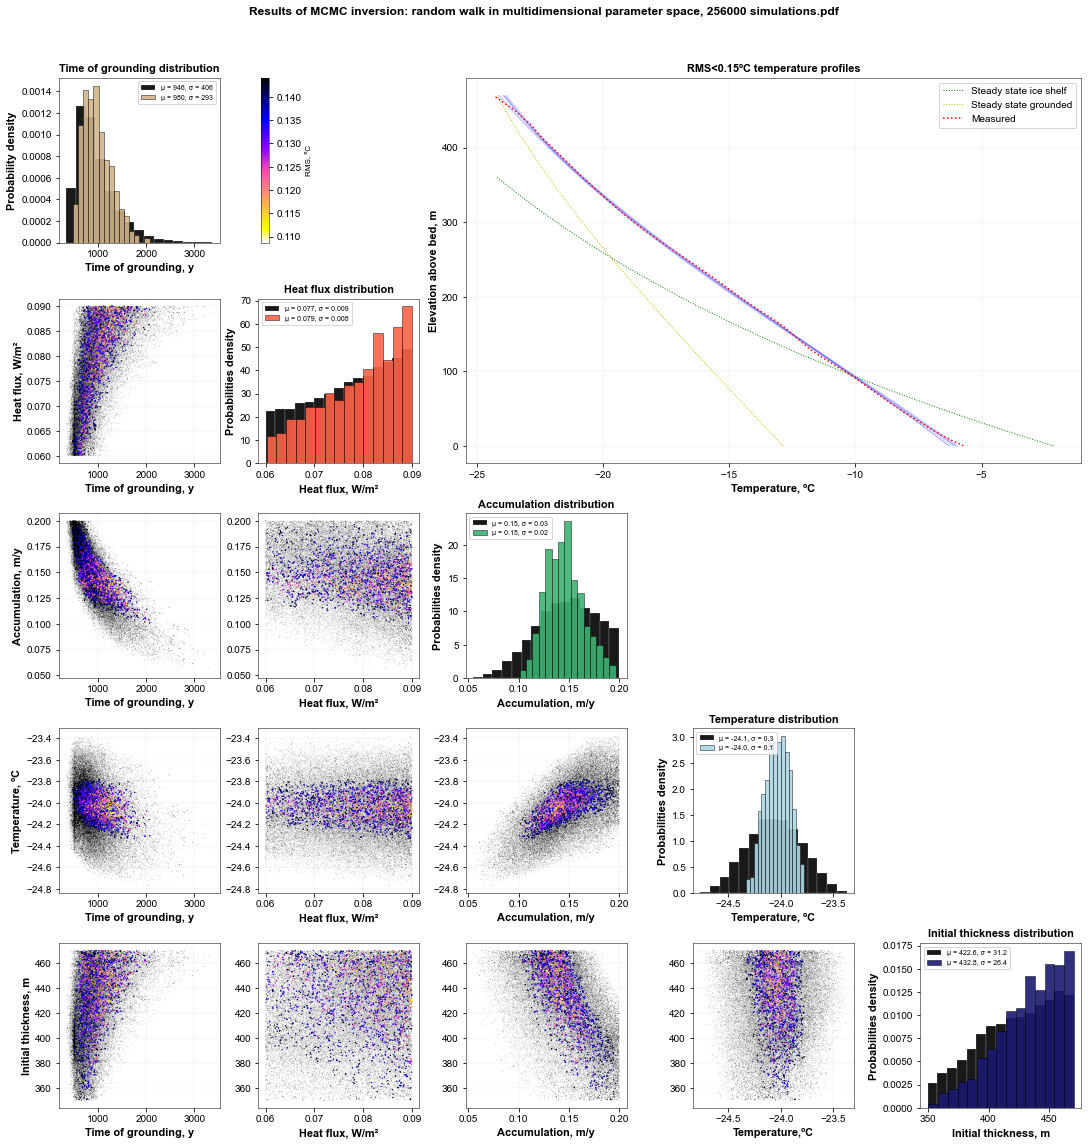

CPU times: user 1min 28s, sys: 1.81 s, total: 1min 30s
Wall time: 1min 28s


In [164]:
%%time

# mpl.rcParams['figure.dpi'] = 200

fig = plt.figure(figsize=(15, 15), constrained_layout=True)

# fig, ax = plt.subplots(figsize=(15, 15), ncols=5, nrows = 5)
fig.tight_layout(pad=2.0)

fig.suptitle('Results of MCMC inversion: random walk in multidimensional parameter space, {:0.0f} simulations.pdf'.format(len(samples)), y=1.05)

gs = GridSpec(5, 5, figure=fig)


ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(xs, 15, density=True, facecolor='black', edgecolor='white', alpha=0.9, linewidth=0.2, label = "\u03bc = {:0.0f}, \u03C3 = {:0.0f}".format(np.mean(xs),np.std(xs)))
ax1.hist(xs1, 15, density=True, facecolor='tan', edgecolor='black', alpha=0.9, linewidth=0.5, label = "\u03bc = {:0.0f}, \u03C3 = {:0.0f}".format(np.mean(xs1),np.std(xs1)))
ax1.set_xlabel('Time of grounding, y')
ax1.set_ylabel('Probability density')
ax1.set_title('Time of grounding distribution')
ax1.legend(borderpad=0.5,prop={'size':7})


ax2 = fig.add_subplot(gs[0:2, 2:5])
for theta in (samples[(probabilities>lnprobmax)])[np.random.randint(len(samples[(probabilities>lnprobmax)]), size=10)]:
    ax2.plot(model_measured(theta, z), z[l-1:], 'b', linewidth=0.25, alpha=0.5)
# ax2.plot(model_measured(theta, z), z[l-1:], 'b', linewidth=0.25, alpha=1, label = '{:0.2f} fit'.format(lnprobmax))
# for theta in (samples[(probabilities>lnprobmin)])[np.random.randint(len(samples[(probabilities>lnprobmin)]), size=10)]:
#     ax2.plot(model_measured(theta, z), z[l-1:], 'b', linewidth=0.25, alpha=0.7)
ax2.plot(Tsteady_ice_shelf[l-1:], z[l-1:-11], 'g:', linewidth=1, label='Steady state ice shelf')
ax2.plot(Tsteady_grounded[l-1:], z[l-1:], 'y:', linewidth=1, label='Steady state grounded')
# ax2.plot(model_measured(theta, z), z[l-1:], 'k', linewidth=0.15, alpha=0.5, label = '{:0.2f} fit'.format(lnprobmin))
ax2.plot(Tmeasured, z[l-1:],'r:', linewidth=1.5,  label='Measured')
ax2.set_xlabel('Temperature, ºC')
ax2.set_ylabel('Elevation above bed, m')
ax2.grid(linestyle='-', linewidth=0.1)
ax2.legend()
# ax2.set_title('{:0.2f} likelihood fit temperature profiles'.format(lnprobmax))
ax2.set_title('RMS<0.15ºC temperature profiles')

ax3 = fig.add_subplot(gs[1, 0])
pc0 = ax3.scatter(xs, ys,c= 'k', s = 0.5, alpha=0.05,edgecolors='none', cmap='gnuplot2_r')
pc0 = ax3.scatter(xs1, ys1,c= rmslik, s = 2, alpha=1,edgecolors='none', cmap='gnuplot2_r')
# ax3.axhline(0.077, color='y', linestyle='-', linewidth=0.5)
# ax3.axvline(1100, color='y', linestyle='-', linewidth=0.5)
# ax[0].axhspan(0.040, 0.060, facecolor='y', alpha=0.05)
ax3.grid(linestyle='-', linewidth=0.1)
ax3.set_xlabel('Time of grounding, y')
ax3.set_ylabel('Heat flux, W/m²')
# fig.colorbar(pc0, ax=ax[2,0]).set_label('Accumulation, m/y',weight = 'light',size = 8)
# ax3.legend()


ax4 = fig.add_subplot(gs[2, 0])
pc1 = ax4.scatter(xs, zs, c = 'k', s = 0.5, alpha=0.05, edgecolors='none',cmap='gnuplot2_r')
pc1 = ax4.scatter(xs1, zs1,c = rmslik, s = 2, alpha=1,edgecolors='none',cmap='gnuplot2_r')
ax4.grid(linestyle='-', linewidth=0.1)
# ax4.axhline(0.11, color='y', linestyle='-', linewidth=0.5)
# ax4.axvline(1100, color='y', linestyle='-', linewidth=0.5)
ax4.set_xlabel('Time of grounding, y')
ax4.set_ylabel('Accumulation, m/y')
# fig.colorbar(pc1, ax=ax[2,0]).set_label('Heat flux, W/m²',weight = 'light',size = 8)
# ax[2,0].legend()


ax5 = fig.add_subplot(gs[3, 0])
pc0 = ax5.scatter(xs, ts,c= 'k', s = 0.5, alpha=0.05,edgecolors='none', cmap='gnuplot2_r')
pc0 = ax5.scatter(xs1, ts1,c= rmslik, s = 2, alpha=1,edgecolors='none', cmap='gnuplot2_r')
# ax5.axhline(-24, color='y', linestyle='-', linewidth=0.5)
# ax5.axvline(1100, color='y', linestyle='-', linewidth=0.5)
# ax[0].axhspan(0.040, 0.060, facecolor='y', alpha=0.05)
ax5.grid(linestyle='-', linewidth=0.1)
ax5.set_xlabel('Time of grounding, y')
ax5.set_ylabel('Temperature, ºC')
# fig.colorbar(pc0, ax=ax[2,0]).set_label('Accumulation, m/y',weight = 'light',size = 8)
# ax[3,0].legend()


ax6 = fig.add_subplot(gs[4, 0])
pc0 = ax6.scatter(xs, hs,c= 'k', s = 0.5, alpha=0.05,edgecolors='none', cmap='gnuplot2_r')
pc0 = ax6.scatter(xs1, hs1,c= rmslik, s = 2, alpha=1,edgecolors='none', cmap='gnuplot2_r')
# ax6.axhline(-24, color='y', linestyle='-', linewidth=0.5)
# ax6.axvline(1100, color='y', linestyle='-', linewidth=0.5)
# ax[0].axhspan(0.040, 0.060, facecolor='y', alpha=0.05)
ax6.grid(linestyle='-', linewidth=0.1)
ax6.set_xlabel('Time of grounding, y')
ax6.set_ylabel('Initial thickness, m')
# fig.colorbar(pc0, ax=ax[2,0]).set_label('Accumulation, m/y',weight = 'light',size = 8)
# ax[3,0].legend()


ax7 = fig.add_subplot(gs[1, 1])
ax7.hist(ys, 15, density=True, facecolor='black', edgecolor='white', alpha=0.9, linewidth=0.2, label = "\u03bc = {:0.3f}, \u03C3 = {:0.3f}".format(np.mean(ys),np.std(ys)))
ax7.hist(ys1, 15, density=True, facecolor='tomato', edgecolor='black', alpha=0.9, linewidth=0.5, label = "\u03bc = {:0.3f}, \u03C3 = {:0.3f}".format(np.mean(ys1),np.std(ys1)))
ax7.set_xlabel('Heat flux, W/m²')
ax7.set_ylabel('Probabilities density')
ax7.set_title('Heat flux distribution')
ax7.legend(borderpad=0.5,prop={'size':7})


ax8 = fig.add_subplot(gs[2, 1])
pc2 = ax8.scatter(ys, zs, c = 'k', s = 0.5, alpha=0.05, edgecolors='none',cmap='gnuplot2_r')
pc2 = ax8.scatter(ys1, zs1,c= rmslik, s = 2, alpha=1,edgecolors='none',cmap='gnuplot2_r')
# ax[2].axvspan(0.040, 0.060, facecolor='y', alpha=0.05)
# ax8.axvline(0.077, color='y', linestyle='-', linewidth=0.5)
# ax8.axhline(0.11, color='y', linestyle='-', linewidth=0.5)
ax8.grid(linestyle='-', linewidth=0.1)
ax8.set_xlabel('Heat flux, W/m²')
# ax[2,1].set_ylabel('Accumulation, m/y')
# fig.colorbar(pc2, ax=ax[2,1]).set_label('Grounding, years ago',weight = 'light',size = 8)
# ax[2,1].legend()


ax9 = fig.add_subplot(gs[3, 1])
pc3 = ax9.scatter(ys, ts, c = 'k', s = 0.5, alpha=0.05, edgecolors='none',cmap='gnuplot2_r')
pc3 = ax9.scatter(ys1, ts1,c= rmslik, s = 2, alpha=1,edgecolors='none',cmap='gnuplot2_r')
# ax[2].axvspan(0.040, 0.060, facecolor='y', alpha=0.05)
# ax9.axvline(0.077, color='y', linestyle='-', linewidth=0.5)
# ax9.axhline(-24, color='y', linestyle='-', linewidth=0.5)
ax9.grid(linestyle='-', linewidth=0.1)
ax9.set_xlabel('Heat flux, W/m²')
# ax[3,1].set_ylabel('Temperature, ºC')
# fig.colorbar(pc2, ax=ax[3,1]).set_label('Grounding, years ago',weight = 'light',size = 8)
# ax[3,1].legend()


ax10 = fig.add_subplot(gs[4, 1])
pc3 = ax10.scatter(ys, hs, c = 'k', s = 0.5, alpha=0.05, edgecolors='none',cmap='gnuplot2_r')
pc3 = ax10.scatter(ys1, hs1,c= rmslik, s = 2, alpha=1,edgecolors='none',cmap='gnuplot2_r')
# ax[2].axvspan(0.040, 0.060, facecolor='y', alpha=0.05)
# ax10.axvline(0.077, color='y', linestyle='-', linewidth=0.5)
# ax10.axhline(-24, color='y', linestyle='-', linewidth=0.5)
ax10.grid(linestyle='-', linewidth=0.1)
ax10.set_xlabel('Heat flux, W/m²')
# ax[3,1].set_ylabel('Temperature, ºC')
# fig.colorbar(pc2, ax=ax[3,1]).set_label('Grounding, years ago',weight = 'light',size = 8)
# ax[3,1].legend()


ax11 = fig.add_subplot(gs[2, 2])
ax11.hist(zs, 15, density=True, facecolor='black', edgecolor='white', alpha=0.9, linewidth=0.2, label = "\u03bc = {:0.2f}, \u03C3 = {:0.2f}".format(np.mean(zs),np.std(zs)))
ax11.hist(zs1, 15, density=True, facecolor='mediumseagreen', edgecolor='black', alpha=0.9, linewidth=0.5, label = "\u03bc = {:0.2f}, \u03C3 = {:0.2f}".format(np.mean(zs1),np.std(zs1)))
ax11.set_xlabel('Accumulation, m/y')
ax11.set_ylabel('Probabilities density')
ax11.set_title('Accumulation distribution')
ax11.legend(borderpad=0.5,prop={'size':7})


ax12 = fig.add_subplot(gs[3, 2])
pc3 = ax12.scatter(zs, ts, c = 'k', s = 0.5, alpha=0.05, edgecolors='none',cmap='gnuplot2_r')
pc3 = ax12.scatter(zs1, ts1,c= rmslik, s = 2, alpha=1,edgecolors='none',cmap='gnuplot2_r')
# ax[2].axvspan(0.040, 0.060, facecolor='y', alpha=0.05)
# ax12.axvline(0.11, color='y', linestyle='-', linewidth=0.5)
# ax12.axhline(-24, color='y', linestyle='-', linewidth=0.5)
ax12.grid(linestyle='-', linewidth=0.1)
ax12.set_xlabel('Accumulation, m/y')
# ax[3,2].set_ylabel('Temperature, ºC')
# fig.colorbar(pc2, ax=ax[3,1]).set_label('Grounding, years ago',weight = 'light',size = 8)
# ax[3,2].legend()

ax13 = fig.add_subplot(gs[4, 2])
pc3 = ax13.scatter(zs, hs, c = 'k', s = 0.5, alpha=0.05, edgecolors='none',cmap='gnuplot2_r')
pc3 = ax13.scatter(zs1, hs1,c= rmslik, s = 2, alpha=1,edgecolors='none',cmap='gnuplot2_r')
# ax[2].axvspan(0.040, 0.060, facecolor='y', alpha=0.05)
# ax13.axvline(0.11, color='y', linestyle='-', linewidth=0.5)
# ax13.axhline(-24, color='y', linestyle='-', linewidth=0.5)
ax13.grid(linestyle='-', linewidth=0.1)
ax13.set_xlabel('Accumulation, m/y')
# ax[3,2].set_ylabel('Temperature, ºC')
# fig.colorbar(pc2, ax=ax[3,1]).set_label('Grounding, years ago',weight = 'light',size = 8)
# ax[3,2].legend()


ax14 = fig.add_subplot(gs[3, 3])
ax14.hist(ts, 15, density=True, facecolor='black', edgecolor='white', alpha=0.9, linewidth=0.2, label = "\u03bc = {:0.1f}, \u03C3 = {:0.1f}".format(np.mean(ts),np.std(ts)))
ax14.hist(ts1, 15, density=True, facecolor='lightblue', edgecolor='black', alpha=0.9, linewidth=0.5, label = "\u03bc = {:0.1f}, \u03C3 = {:0.1f}".format(np.mean(ts1),np.std(ts1)))
ax14.set_xlabel('Temperature, ºC')
ax14.set_ylabel('Probabilities density')
ax14.set_title('Temperature distribution')
ax14.legend(borderpad=0.5,prop={'size':7})


ax15 = fig.add_subplot(gs[4, 3])
pc3 = ax15.scatter(ts, hs, c = 'k', s = 0.5, alpha=0.05, edgecolors='none',cmap='gnuplot2_r')
pc3 = ax15.scatter(ts1, hs1,c= rmslik, s = 2, alpha=1,edgecolors='none',cmap='gnuplot2_r')
# ax[2].axvspan(0.040, 0.060, facecolor='y', alpha=0.05)
# ax15.axvline(0.11, color='y', linestyle='-', linewidth=0.5)
# ax15.axhline(-24, color='y', linestyle='-', linewidth=0.5)
ax15.grid(linestyle='-', linewidth=0.1)
ax15.set_xlabel('Temperature,ºC')
# ax[3,2].set_ylabel('Temperature, ºC')
# fig.colorbar(pc2, ax=ax[3,1]).set_label('Grounding, years ago',weight = 'light',size = 8)
# ax[3,2].legend()

ax16 = fig.add_subplot(gs[4, 4])
ax16.hist(hs, 15, density=True, facecolor='black', edgecolor='white', alpha=0.9, linewidth=0.2, label = "\u03bc = {:0.1f}, \u03C3 = {:0.1f}".format(np.mean(hs),np.std(hs)))
ax16.hist(hs1, 15, density=True, facecolor='midnightblue', edgecolor='black', alpha=0.9, linewidth=0.5, label = "\u03bc = {:0.1f}, \u03C3 = {:0.1f}".format(np.mean(hs1),np.std(hs1)))
ax16.set_xlabel('Initial thickness, m')
ax16.set_ylabel('Probabilities density')
ax16.set_title('Initial thickness distribution')
ax16.legend(borderpad=0.5,prop={'size':7})

ax17 = fig.add_subplot(gs[0, 1])
fig.colorbar(pc3, ax=ax17, orientation="vertical", pad=-1.0).set_label('RMS, ºC',weight = 'light',size = 8)
ax17.xaxis.set_visible(False)
ax17.yaxis.set_visible(False)
ax17.axis("off")
plt.show()

# fig.suptitle("GridSpec")
# format_axes(f

plt.show()

fig.savefig('Crary_inversion_time_variable_temp_profile_w_ice_shelf{:0.0f}_simulations.pdf'.format(len(samples)))


#### 

### 6. Distribution of key forcings in Antarctic ice rises

Ultimately, the primary purpose of the paper is to examine what information about climate and glacial history can be inferred from englacial temperatures measured within ice rises. Therefore, to provide some context for the models presented above, we load the Antarctic ice rises inventory by [Matsouka et al 2015](https://www.sciencedirect.com/science/article/pii/S0012825215300416), and produce a map that shows the locations of present-day ice rises with respect to distribution of geothermal heat flux and surface mass balance of the Antarctic Ice Sheet.

Importing ice rise inventory and extracting coordinates of ice rises and converting from projected to WGS84 coordinate system:

In [22]:
icerises = gpd.read_file('Antarctic ice rises inventory from Matsouka et al 2015/IceRisesInventory_v1/icerises_inventory_v1.shp')
ir = icerises[icerises['type']<3]

proj = pyproj.Transformer.from_crs(4326, 3031, always_xy=True)

longi = np.array(ir.longi)
lati = np.array(ir.lati)

xirlong, yirlat = (longi, lati) 
x2, y2 = proj.transform(xirlong, yirlat)

Importing RACMO climate model and converting from projected to WGS84 coordinate system:

In [23]:
ds = xr.open_dataset('RACMO smb model 1979-2014/RACMO2.3p1_ANT27_SMB_yearly_1979_2014.nc')
smb = ds.smb

rad2deg = 180./np.pi

p = pyproj.Proj('+ellps=WGS84 +proj=ob_tran +o_proj=latlon +o_lat_p=-180.0 +o_lon_p=-170.0 +lon_0=180.0')

rlon = ds.rlon.values
rlat = ds.rlat.values

xmesh,ymesh = np.meshgrid(rlon, rlat)

lon, lat = p(xmesh, ymesh) 
lon, lat = lon*rad2deg, lat*rad2deg    # radians --> degrees

Extracting surface mass balance data at ice rise locations based on the RACMO model:

In [24]:
smb_data = smb.mean(dim = 'time')
smb_data = np.array(smb_data)
smb_data_rshp = smb_data.reshape(len(rlat), len(rlon))

tck = scipy.interpolate.bisplrep(lon, lat, smb_data_rshp*24*365*3600, s = 0)

smb_ice_rises = []

for i in range(len(xirlong)):
    smb_1 = scipy.interpolate.bisplev(xirlong[i],yirlat[i],tck)
    smb_ice_rises.append(smb_1)

smb_ice_rises = np.array(smb_ice_rises)
smb_ice_rises[smb_ice_rises<0] = 0

/Users/wolf/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=3,3 nx,ny=51,46 m=62880 fp=398425226.938813 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


Importing heat flux data and converting from projected to WGS84 coordinate system:

In [25]:
f = open(('Antarctic GHF model from Martos et al 2017/Antarctic_GHF_Martos.xyz'), 'r')

xval = np.zeros(0)
yval = np.zeros(0)
bhflx = np.zeros(0)

for i,line in enumerate(f):
        line = line.strip()
        columns = line.split()
        xval=np.append(xval, float(columns[0]))
        yval=np.append(yval, float(columns[1]))
        bhflx=np.append(bhflx, float(columns[2]))
f.close()

In [26]:
x_new = np.sort(np.unique(xval)) # are sorted already
y_new = np.sort(np.unique(yval))

fillvalue = -9.e+33
bheatflx = np.zeros((len(y_new), len(x_new))) + fillvalue

for i in range(len(bhflx)):
    # go through all vals and fill them into the right place
    ix = np.in1d(x_new.ravel(), xval[i]).reshape(x_new.shape)
    iy = np.in1d(y_new.ravel(), yval[i]).reshape(y_new.shape)
    bheatflx[iy,ix] = bhflx[i]*1.0e-3


hf = np.array(bheatflx)
hf = hf.reshape((len(y_new), len(x_new)))

Extracting heat flux data at ice rise locations:

In [27]:
X,Y = np.meshgrid(x_new, y_new)

xs = X.reshape((350*291, 1))
ys = Y.reshape((350*291, 1))

points = np.array([x2, y2])

hf_ice_rises = []

for i in range(len(x2)):
    hf_1 = zs2 = scipy.interpolate.griddata(np.hstack((xs, ys)), hf.reshape(-1), points[:,i])
    hf_ice_rises.append(hf_1)

hf_ice_rises = np.array(hf_ice_rises)
hf_ice_rises[hf_ice_rises>1e-01] = np.nan
hf_ice_rises[hf_ice_rises<0] = np.nan

Plotting the distribution of key ice-rise parameters across the Antarctic Ice Sheet

Text(0.5, 1.0, 'Heat flux')

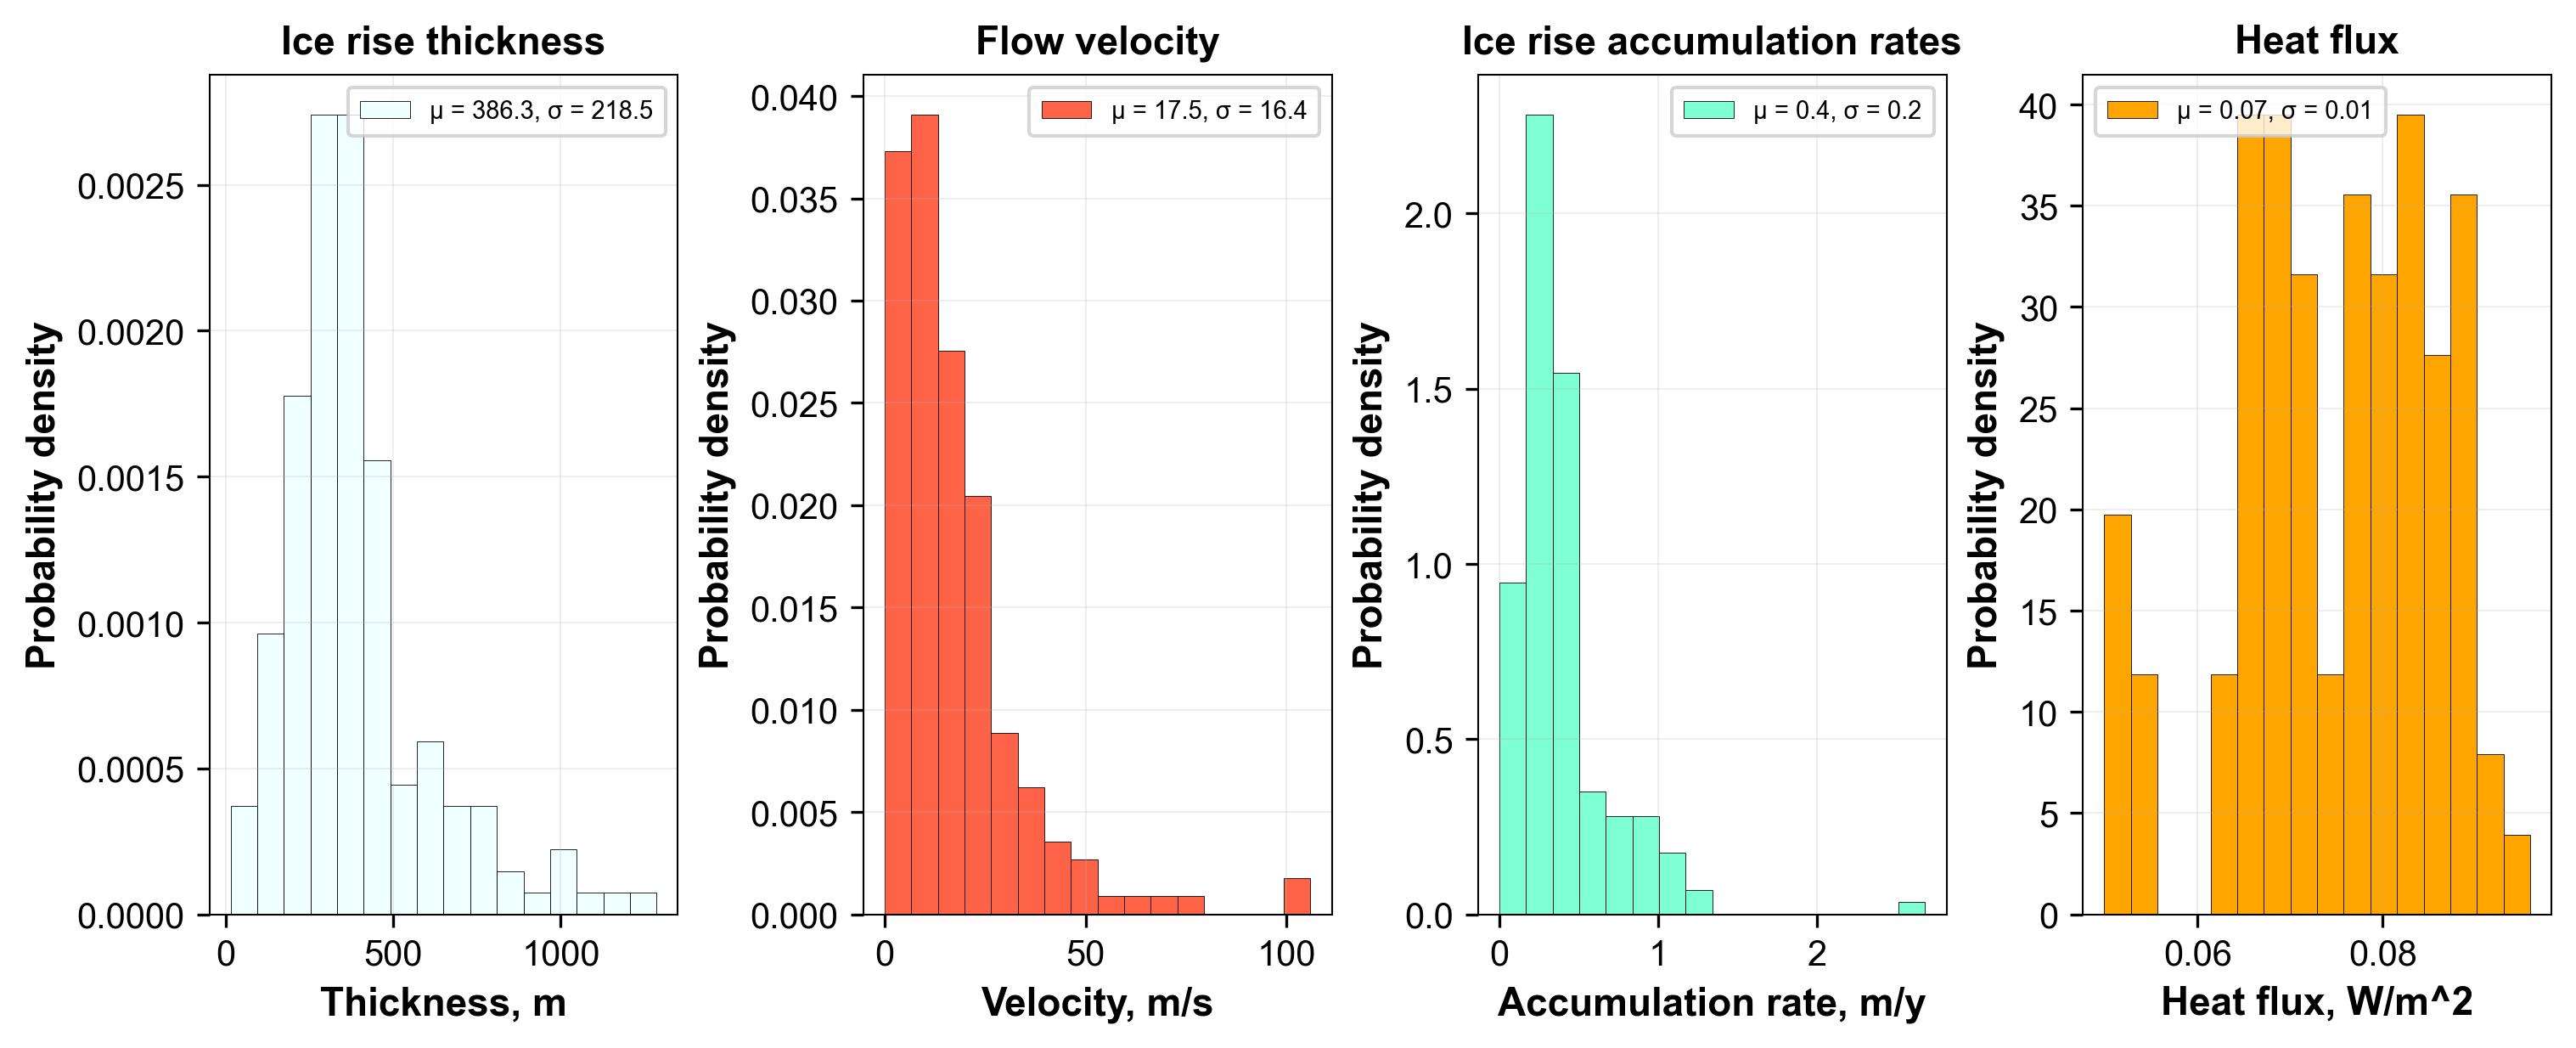

In [28]:
fig, ax = plt.subplots(1, 4, figsize=(10, 4), constrained_layout=True)

irthick = np.array(ir.thick)
irthick[irthick == -9999.0] = 0

vel_mean = np.array(ir.vel_mean)
vel_mean[vel_mean == -9999.0] = 0
vel_mean[vel_mean == 608.136446] = 0

ax[0].hist(irthick, 16, density=True, facecolor='azure', edgecolor='black', alpha=1, linewidth=0.2, label = "\u03bc = {:0.1f}, \u03C3 = {:0.1f}".format(np.mean(irthick),np.std(irthick)))
ax[0].grid()
ax[0].legend(borderpad=0.5,prop={'size':7})
ax[0].set_xlabel('Thickness, m')
ax[0].set_ylabel('Probability density')
ax[0].set_title('Ice rise thickness')

ax[1].hist(vel_mean, 16, density=True, facecolor='tomato', edgecolor='black', alpha=1, linewidth=0.2, label = "\u03bc = {:0.1f}, \u03C3 = {:0.1f}".format(np.mean(vel_mean),np.std(vel_mean)))
ax[1].grid()
ax[1].legend(borderpad=0.5,prop={'size':7})
ax[1].set_xlabel('Velocity, m/s')
ax[1].set_ylabel('Probability density')
ax[1].set_title('Flow velocity')

ax[2].hist(smb_ice_rises/918, 16, density=True, facecolor='aquamarine', edgecolor='black', alpha=1, linewidth=0.2, label = "\u03bc = {:0.1f}, \u03C3 = {:0.1f}".format(np.nanmean(smb_ice_rises/918),np.nanstd(smb_ice_rises//918)))
ax[2].grid()
ax[2].legend(borderpad=0.5,prop={'size':7})
ax[2].set_xlabel('Accumulation rate, m/y')
ax[2].set_ylabel('Probability density')
ax[2].set_title('Ice rise accumulation rates')


ax[3].hist(hf_ice_rises, 16, density=True, facecolor='orange', edgecolor='black', alpha=1, linewidth=0.2, label = "\u03bc = {:0.2f}, \u03C3 = {:0.2f}".format(np.nanmean(hf_ice_rises),np.nanstd(hf_ice_rises)))
ax[3].grid()
ax[3].legend(borderpad=0.5,prop={'size':7})
ax[3].set_xlabel('Heat flux, W/m^2')
ax[3].set_ylabel('Probability density')
ax[3].set_title('Heat flux')


# fig.savefig('Ice rise statistics.pdf')

Text(0, 0.5, 'y, m')

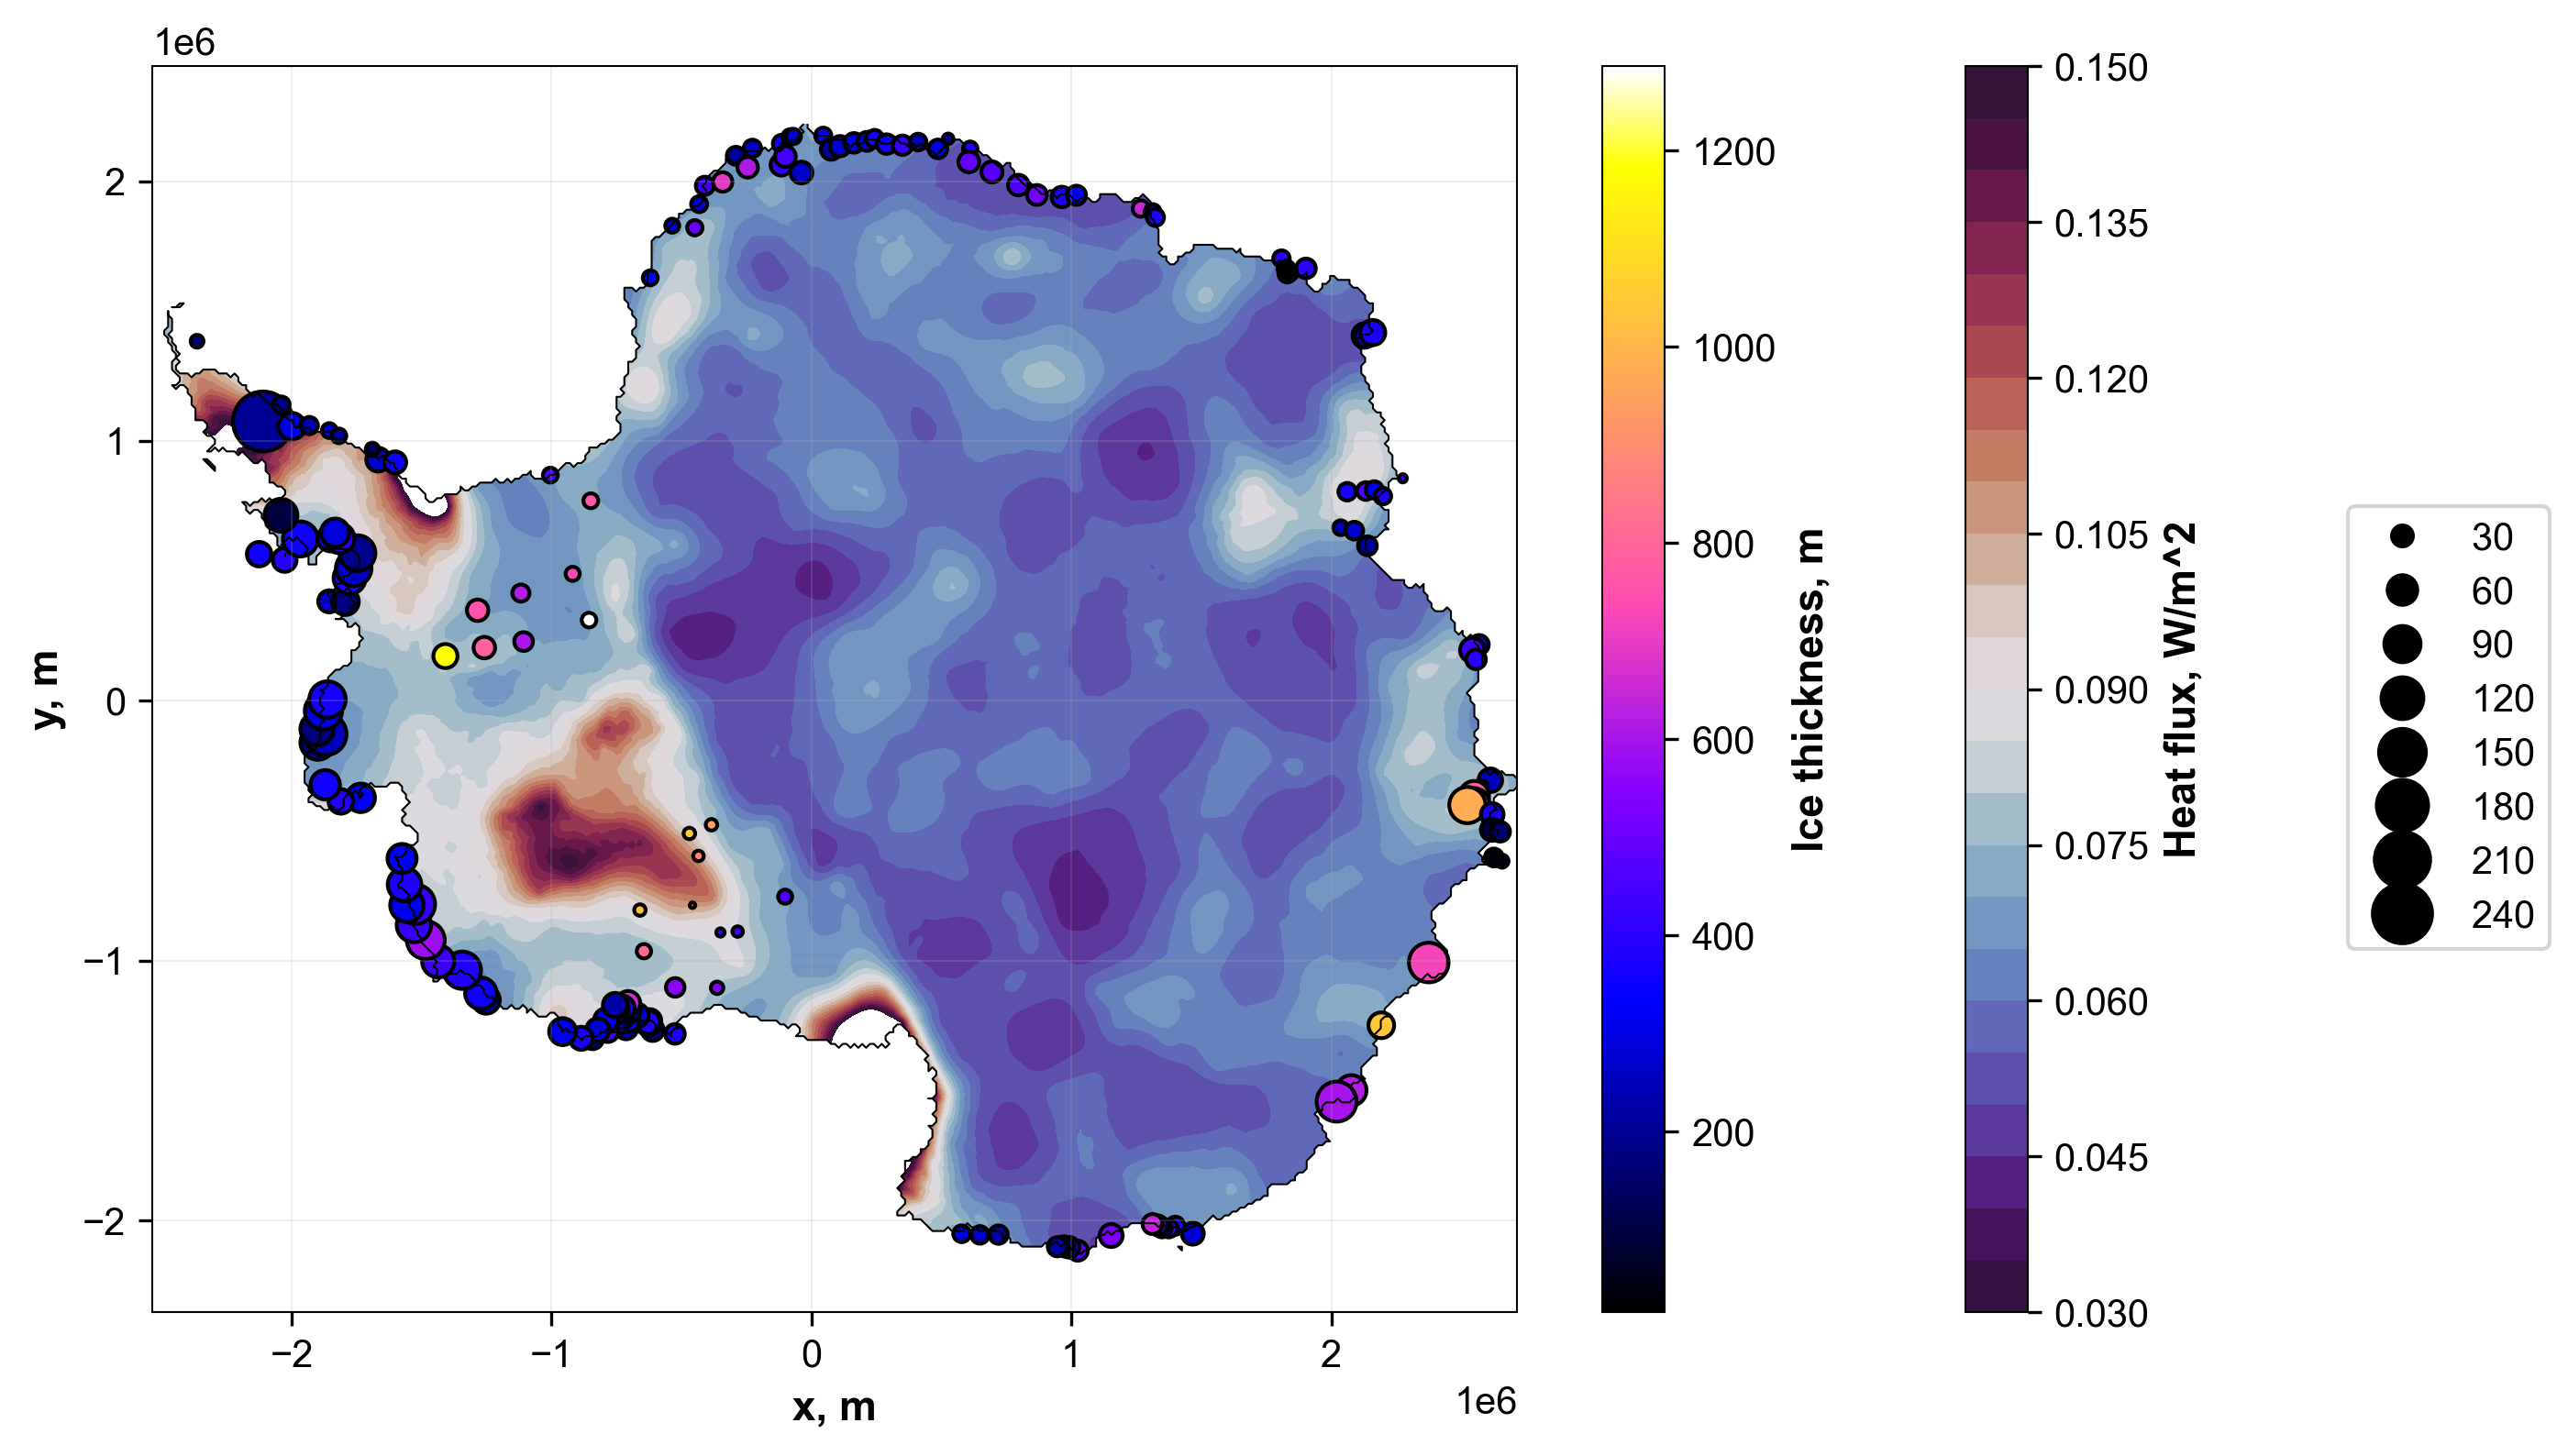

In [43]:
fig, axes = plt.subplots(figsize=(10,6))
ax1 = axes

pcm = ax1.contourf(x_new, y_new, hf, alpha= 1, levels=np.linspace(0.03,0.15, num=25), cmap="twilight_shifted")
cbar1 = fig.colorbar(pcm, ax=ax1)
cbar1.set_label('Heat flux, W/m^2')
ax1.contour(x_new, y_new, hf, levels=0, colors ='k',linewidths=0.5)
sc = ax1.scatter(x2, y2, alpha = 1, s=smb_ice_rises/10, c=irthick, edgecolors = 'k', linewidths = 1, cmap="gnuplot2")
cbar2 = fig.colorbar(sc, ax=ax1)
cbar2.set_label('Ice thickness, m')
fig.legend(*sc.legend_elements("sizes", num=8), loc = 'center right', prop={'size': 10})
ax1.axis('equal')
ax1.grid()
ax1.set_xlabel('x, m')
ax1.set_ylabel('y, m')


# fig.savefig('Ice rise dating locations.pdf')